<a href="https://colab.research.google.com/github/marchesiniid/EEA-2023/blob/main/Especializacion/DMCyT/TPs/TP2/TP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
#Path del archivo en Github
github_file = "Especializacion/DMCyT/TPs/TP2/TP2.ipynb"
github_file

'Especializacion/DMCyT/TPs/TP2/TP2.ipynb'

In [ ]:
!pip install powerlaw

## Importamos librerias

In [ ]:
# Sistema de archivos
from google.colab import drive  # Montar Google Drive si es necesario
from glob import glob  # Búsqueda de archivos coincidentes
from pathlib import Path  # Manipulación de rutas de archivos
import os  # Operaciones del sistema operativo

# Visualización en el cuaderno
import matplotlib.pyplot as plt  # Trazado de gráficos
import matplotlib as mpl  # Configuración de trazado personalizada
import seaborn as sns  # Trazado con estilo

# Manipulación de números y datos
import numpy as np  # Manipulación de matrices y cálculos numéricos
import pandas as pd  # Manipulación de datos tabulares

# Redes
import networkx as nx  # Trabajo con grafos y redes

# Métricas
from itertools import combinations  # Generación de combinaciones
from sklearn.metrics import adjusted_rand_score  # Métrica de similitud ajustada de Rand

# Análisis de leyes de potencia
import powerlaw  # Ajuste y análisis de distribuciones de leyes de potencia

# Detección de comunidades
import community.community_louvain as community  # Algoritmo de Louvain para detección de comunidades

# Estadísticas y análisis
from scipy.stats import sem  # Cálculo del error estándar de la media
from scipy.stats import ttest_ind, wilcoxon  # Pruebas de hipótesis estadísticas
from matplotlib.colors import LinearSegmentedColormap  # Mapa de colores segmentado linealmente
from networkx.algorithms import community as gn  # Algoritmos de comunidad en NetworkX
import re  # Expresiones regulares
from matplotlib.colors import ListedColormap  # Mapa de colores listado
import random  # Generación de números aleatorios
from itertools import islice  # Cortar iterables

## Variables Globales

In [ ]:
#Montamos el google drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Variables globales
sns.set_context('poster')
sns.set(font_scale = 0.8)  # Ajusta el tamaño global de las fuentes

mpl.rcParams['figure.figsize'] = (8,6)

#Paths
dataset_path = "/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/"
working_path = "/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/"

# Carga y Preprocesamiento de los datos

## Bajar Atlas (Regiones Cerebrales)
### Son 116 regiones cerebrales
La columna "1" indica el nombre de la subregión, la columna "3" indica a qué región cerebral pertenece, la columna "4" en qué hemisferio se localiza (L=izquierda, R=derecham, --= está en la línea media), las columnas "5", "6" y "7" indican las coordenadas x, y, z de cada subregión

In [ ]:
RegionsNames = pd.read_csv(dataset_path + "aal_extended_withCoords.csv", header=None).iloc[:,1:]
RegionsNames

1     2          3   4   5   6   7
0         Precentral_L  2001    Central   L -39  -6  51
1         Precentral_R  2002    Central   R  41  -8  52
2        Frontal_Sup_L  2101    Frontal   L -18  35  42
3        Frontal_Sup_R  2102    Frontal   R  22  31  44
4    Frontal_Sup_Orb_L  2111    Frontal   L -17  47 -13
..                 ...   ...        ...  ..  ..  ..  ..
111           Vermis_6  9130  Cerebelum  --   2 -67 -15
112           Vermis_7  9140  Cerebelum  --   2 -72 -25
113           Vermis_8  9150  Cerebelum  --   2 -64 -34
114           Vermis_9  9160  Cerebelum  --   2 -55 -35
115          Vermis_10  9170  Cerebelum  --   1 -46 -32

[116 rows x 7 columns]

## Bajar archivos de los sujetos
Tenemos varios sujetos para 4 condiciones, una correspondiente a vigilia y 3 a diferentes estadios del sueño no REM (*rapid eye movement*):<br>

"W": despierto ("Wake")
<br> "N1": sueño "leve"
<br>"N2": sueño "intermedio"
<br>"N3": sueño "profundo"

In [ ]:
#Leo el archivo
files = os.listdir(dataset_path + 'DataSujetos/')
files[1:7]

['N3_suj17.csv',
 'N2_suj9.csv',
 'W_suj10.csv',
 'N3_suj1.csv',
 'N1_suj15.csv',
 'N1_suj11.csv']

In [ ]:
df = pd.DataFrame(files, columns=['nombre_archivo'])

# Paso 2: Dividir 'nombre_archivo' en varias columnas
df[['estado_sueno', 'sujeto', 'numero_suj']] = df['nombre_archivo'].str.split('_|\.csv', expand=True)

df['numero_suj'] = df['sujeto'].str.extract(r'suj(\d+)').astype(int)


In [ ]:
df.head()

nombre_archivo estado_sueno sujeto  numero_suj
0   N3_suj18.csv           N3  suj18          18
1   N3_suj17.csv           N3  suj17          17
2    N2_suj9.csv           N2   suj9           9
3    W_suj10.csv            W  suj10          10
4    N3_suj1.csv           N3   suj1           1

In [ ]:
valores_distintos = df['estado_sueno'].nunique()

# Mostrar el resultado
print(f'Número de valores distintos en la columna estado_sueno: {valores_distintos}')

Número de valores distintos en la columna estado_sueno: 4


In [ ]:
valores_distintos = df['sujeto'].nunique()

# Mostrar el resultado
print(f'Número de valores distintos en la columna sujeto: {valores_distintos}')

Número de valores distintos en la columna sujeto: 18


Obtener archivos correspondientes a la condición "W" unicamente:

In [ ]:
#Archivos de condicion W
filenames_w = list(Path(dataset_path + 'DataSujetos').glob('W_*.csv'))
filenames_w.sort()
filenames_w

[PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/W_suj1.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/W_suj10.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/W_suj11.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/W_suj12.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/W_suj13.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/W_suj14.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/W_suj15.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/W_suj16.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/W_suj17.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/W_suj18.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataS

In [ ]:
#Archivos de condicion N1

filenames_n1 = list(Path(dataset_path + 'DataSujetos').glob('N1_*.csv'))
filenames_n1.sort()
filenames_n1

[PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/N1_suj1.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/N1_suj10.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/N1_suj11.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/N1_suj12.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/N1_suj13.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/N1_suj14.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/N1_suj15.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/N1_suj16.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/N1_suj17.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/N1_suj18.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dat

In [ ]:
#Archivos de condicion N2

filenames_n2 = list(Path(dataset_path + 'DataSujetos').glob('N2_*.csv'))
filenames_n2.sort()
filenames_n2

[PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/N2_suj1.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/N2_suj10.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/N2_suj11.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/N2_suj12.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/N2_suj13.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/N2_suj14.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/N2_suj15.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/N2_suj16.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/N2_suj17.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/N2_suj18.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dat

In [ ]:
#Archivos de condicion N1

filenames_n3 = list(Path(dataset_path + 'DataSujetos').glob('N3_*.csv'))
filenames_n3.sort()
filenames_n3

[PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/N3_suj1.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/N3_suj10.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/N3_suj11.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/N3_suj12.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/N3_suj13.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/N3_suj14.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/N3_suj15.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/N3_suj16.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/N3_suj17.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/N3_suj18.csv'),
 PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dat

In [ ]:
filenames_todos = {'W':filenames_w, 'N1':filenames_n1, 'N2':filenames_n2, 'N3':filenames_n3 }
filenames_todos

{'W': [PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/W_suj1.csv'),
  PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/W_suj10.csv'),
  PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/W_suj11.csv'),
  PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/W_suj12.csv'),
  PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/W_suj13.csv'),
  PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/W_suj14.csv'),
  PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/W_suj15.csv'),
  PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/W_suj16.csv'),
  PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/W_suj17.csv'),
  PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/Dataset/DataSujetos/W_suj18.csv'),
  PosixPath('/content/drive/MyDrive/Maestria/DMCyT/pre-T

# Funciones auxiliares


In [ ]:
def density_to_th(W, d):
    n = W.shape[0]
    max_links = (n * (n-1)) // 2
    tril_idx = np.tril_indices(n, -1)
    c = sorted(np.array(list(W[tril_idx].reshape(-1))), reverse=True)
    return c[int((len(c)-1) * d)]

In [ ]:
def calcular_matriz(filename):

  #filename = dataset_path + 'DataSujetos/' + sujeto_estudio
  df = pd.read_csv(filename, header=None)

  matAdyacPesada = df.values

  n = matAdyacPesada.shape[0]

  matAdyacPesada -= np.diag(np.ones(n))

  return matAdyacPesada

In [ ]:
def promediar_matrices(filenames):

  l = len(filenames)
  m_total = np.zeros((116, 116))

  for filename in filenames:
    m = calcular_matriz(filename)
    m_total = m_total + m

  m_total = m_total / l
  return m_total

In [ ]:

def visualizar_matriz(matAdyacPesada, titulo, ax):
  sns.set(font_scale=0.8)  # Ajusta el tamaño global de las fuentes
  heatmap = sns.heatmap(matAdyacPesada, ax=ax)  # Utiliza el objeto de ejes proporcionado como argumento
  heatmap.set_title("Matriz adyacencia pesada " + titulo, fontsize=14)

  ax.set_xlim(0, 116)
  ax.set_ylim(0, 116)

In [ ]:
def listar_componentes(G):
  connected_components = list(nx.connected_components(G))

# Imprime los componentes conectados
  for i, component in enumerate(connected_components):
      print(f"Componente {i + 1} - tamaño: {len(component)}: {component}")

In [ ]:
def tamanho_componente_gigante(G):
  components = list(nx.connected_components(G))

  # Find the size of the largest connected component
  tam = max(len(component) for component in components)
  return tam


In [ ]:
def perc_nodes_componente_gigante(G):
  perc = tamanho_componente_gigante(G) / nx.number_of_nodes(G) * 100
  return perc

In [ ]:
def iterar_densidades(m_ady, estadio, densidades, ax):
  componentes_gigantes = []

  for d in densidades:
    G = binarizar_matriz(m_ady, d)
    cg = tamanho_componente_gigante(G)
    perc = perc_nodes_componente_gigante(G)
    componentes_gigantes.append((d, cg, perc))

  df_resultados = pd.DataFrame(componentes_gigantes, columns=['Densidad', 'tam_componente_gigante', 'perc_componente_gigante'])
  scatterplot = sns.scatterplot(x='Densidad', y='perc_componente_gigante', color=colores[estadio], data = df_resultados, ax=ax)
  ax.tick_params(axis='both', which='major', labelsize=14)

  ax.set_ylabel(f'Nodos de la componente gigante {estadio} (%)')
  ax.set_title(f'Estadio {estadio}', fontsize=14)

  #sns.scatterplot(x='Densidad', y='tam_componente_gigante', data = df_resultados)
  #plt.ylabel('Cantidad de Nodos de la componente gigante')

  return(df_resultados)

In [ ]:
def iterar_densidades_coef_clustering(m_ady, densidades, colores, estadio, ax):
  coeficientes_clustering = []

  for d in densidades:
    G = binarizar_matriz(m_ady, d)
    cg = coeficiente_clustering(G)
    coeficientes_clustering.append((d, cg))

  df_resultados = pd.DataFrame(coeficientes_clustering, columns=['Densidad', 'coeficiente_clustering'])
  scatterplot = sns.scatterplot(x='Densidad', y='coeficiente_clustering', color=colores[estadio], data = df_resultados, ax=ax)
  ax.set_title(f'Estadio {estadio}', fontsize=14)

  return(df_resultados)

In [ ]:
def iterar_densidades_grado_medio(m_ady, densidades, colores, estadio, ax):
  grados_medios = []

  for d in densidades:
    G = binarizar_matriz(m_ady, d)
    cg = grado_medio(G)
    grados_medios.append((d, cg))

  df_resultados = pd.DataFrame(grados_medios, columns=['Densidad', 'grado_medio'])
  scatterplot = sns.scatterplot( x = 'Densidad', y = 'grado_medio', color=colores[estadio], data = df_resultados, ax=ax)

  ax.set_title(f'Estadio {estadio}', fontsize=14)

  return(df_resultados)

In [ ]:
def iterar_densidades_eficiencia_global(m_ady, densidades, colores, estadio, ax):
  eficiencias_globales = []

  for d in densidades:
    G = binarizar_matriz(m_ady, d)
    cg = eficiencia_global(G)
    eficiencias_globales.append((d, cg))

  df_resultados = pd.DataFrame(eficiencias_globales, columns=['Densidad', 'eficiencia_global'])
  scatterplot = sns.scatterplot(x='Densidad', y='eficiencia_global', color=colores[estadio], data = df_resultados, ax=ax)
  ax.set_title(f'Estadio {estadio}', fontsize=14)

  return(df_resultados)

In [ ]:
def binarizar_matriz(m_ady, densidad):

  th = density_to_th(m_ady, densidad)
  G = nx.from_numpy_array(m_ady >= th)
  return G


In [ ]:
def grado_medio (G):

  average_degree = sum(dict(G.degree()).values()) / len(G)
  #print(f"Grado promedio (< k >): {average_degree:.2f}")

  return average_degree

def coeficiente_clustering(G):

  average_clustering_coefficient = nx.average_clustering(G)
  #print(f"Coeficiente de agrupamiento promedio (C = <C_i>): {average_clustering_coefficient:.2f}")
  return average_clustering_coefficient

def eficiencia_global(G):
  global_efficiency = nx.global_efficiency(G)
  return global_efficiency


In [ ]:


def graficar_grafo(G, estadio, titulo, ax, colores):
    degrees = G.degree()
    nodes = G.nodes()

    n_color = [colores[estadio] for _ in nodes]

    ax.set_title(f'Grafo por grados estadio {estadio} {titulo}', fontsize=14)

    layout = dict(zip(range(116), np.array([RegionsNames[6].values, RegionsNames[7].values]).T))

    nx.draw(G, layout, node_size=20, node_color=n_color, ax=ax)

# def graficar_grafo(G, estadio, titulo, ax):
#     degrees = G.degree()
#     nodes = G.nodes()

#     n_color = np.asarray([degrees[n] for n in nodes])

#     ax.set_title(f'Grafo promedio estadio {estadio}, {titulo}', fontsize=14)

#     layout = dict(zip(range(116), np.array([RegionsNames[6].values, RegionsNames[7].values]).T))

#     vmin = min(n_color)
#     vmax = max(n_color)
#     cmap = plt.cm.Blues

#     nx.draw(G, layout, node_size=20, node_color=n_color, vmin=vmin, vmax=vmax, cmap=cmap, ax=ax)

#     sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
#     plt.colorbar(sm, ax=ax)

def graficar_grafo_por_centralidad(G, estadio, ax, titulo = "", alfa = 1):

  degrees = G.degree() # Diccionario con ID de nodo y su grado
  nodes = G.nodes()

  #TODO: Usar exp del vector para que crezcan mas los valores
  eigenvector_centrality = nx.eigenvector_centrality(G)


  n_color = np.asarray([eigenvector_centrality[n] for n in nodes])
  bin_edges = np.linspace(n_color.min(), n_color.max(), 11)  # Crear 10 bins
  n_color = np.digitize(n_color, bin_edges)
  n_size = np.asarray([np.round(eigenvector_centrality[n] * 100 * alfa) for n in nodes])


  ax.set_title(f'Grafo por centralidad estadio {estadio} {titulo}' , fontsize=14)

  layout = dict(zip(range(116),np.array([RegionsNames[6].values, RegionsNames[7].values]).T))

  vmin = min(n_color)
  vmax = max(n_color)
  cmap = plt.cm.get_cmap('tab10')


  #nx.draw(G, layout, node_size=n_size, node_color=n_color, vmin=vmin, vmax=vmax,cmap=cmap)
  nx.draw(G, layout, node_size=n_size, node_color=n_color, vmin=vmin, vmax=vmax,cmap=cmap, ax=ax)

  sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
  #plt.colorbar(sm)

  return sm




#Tarea 1: Visualización

In [ ]:
densidades = np.arange(0.025, 0.155, 0.005)
colores = {'W': 'blue', 'R': 'black', 'N1': 'red', 'N2': 'green', 'N3': 'orange'}

## Tarea 1.0: Promedios de matrices de adyacencia

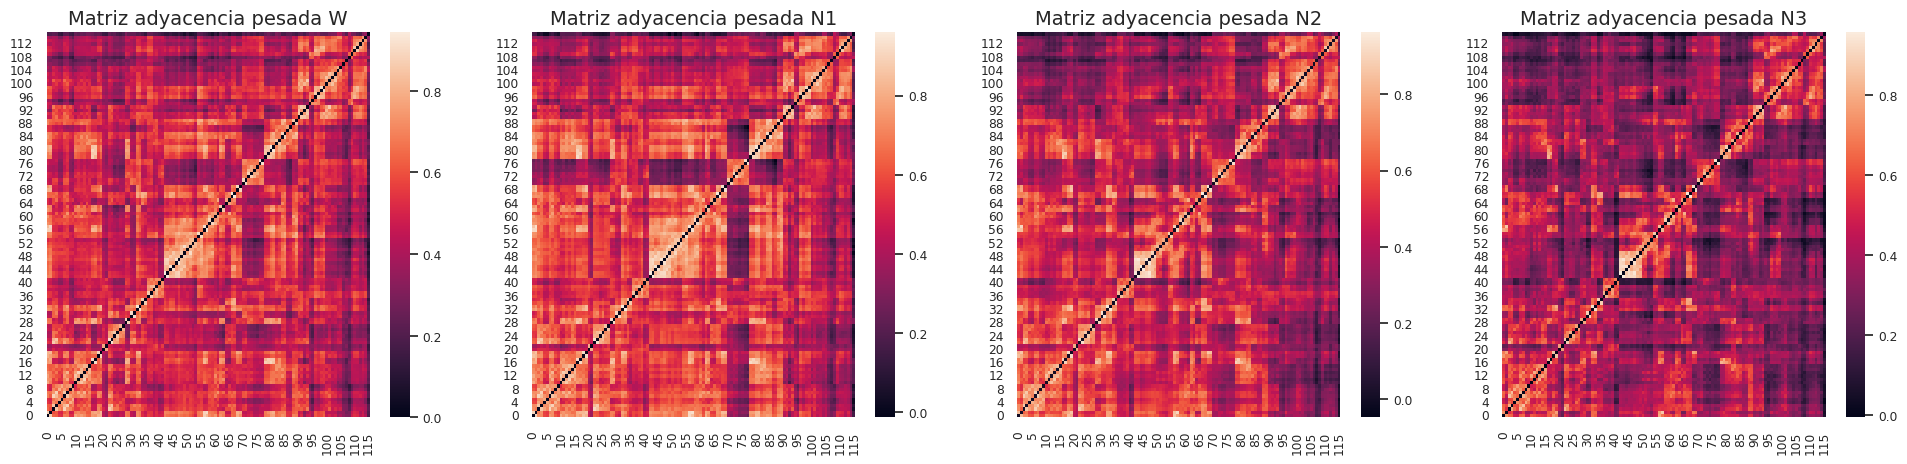

In [ ]:
graficos = ['W', 'N1', 'N2', 'N3']

matrices = {}
matrices ['W'] = promediar_matrices(filenames_w)
matrices ['N1'] = promediar_matrices(filenames_n1)
matrices ['N2'] = promediar_matrices(filenames_n2)
matrices ['N3'] = promediar_matrices(filenames_n3)

fig, axs = plt.subplots(1, 4, figsize=(24, 5))
for i, g in enumerate(graficos):
    visualizar_matriz(matrices[g], g, axs[i])
plt.show()


## Tarea  1.1

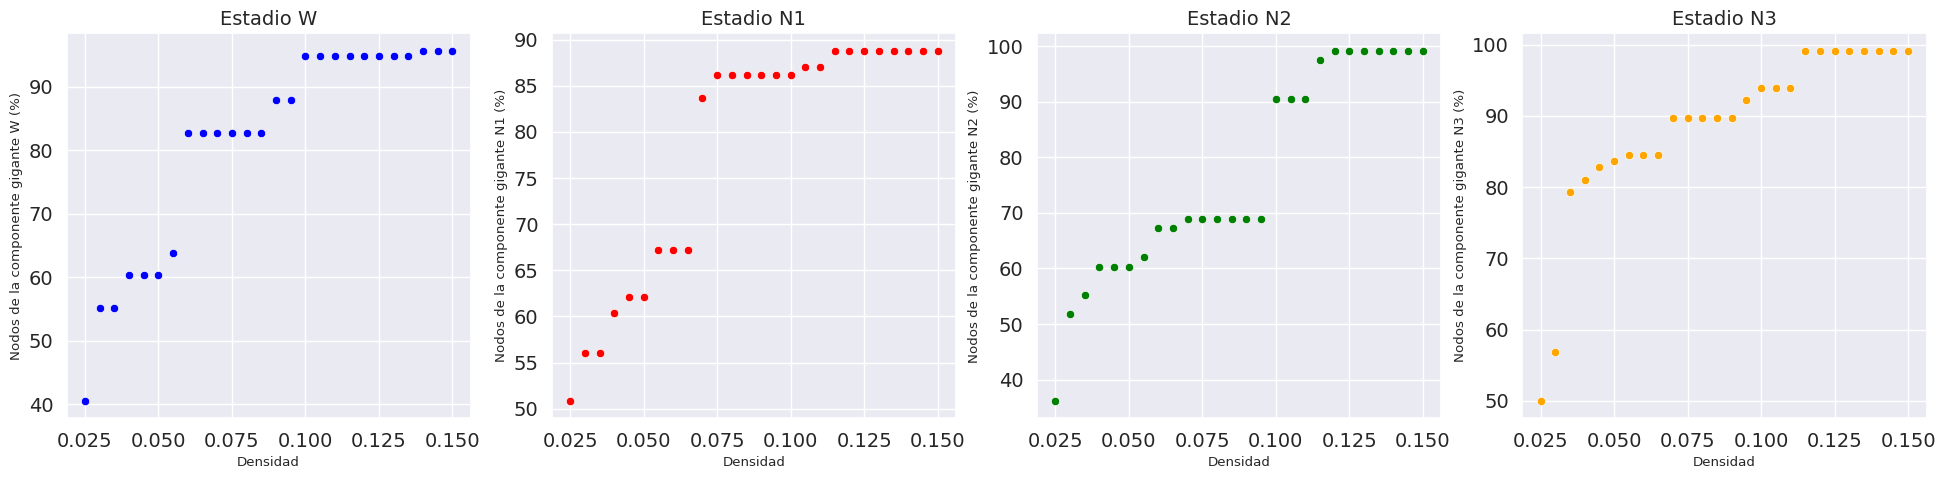

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(24, 5))
for i, g in enumerate(graficos):
    iterar_densidades(matrices[g], g, densidades, axs[i])
plt.show()

##Tarea 1.2

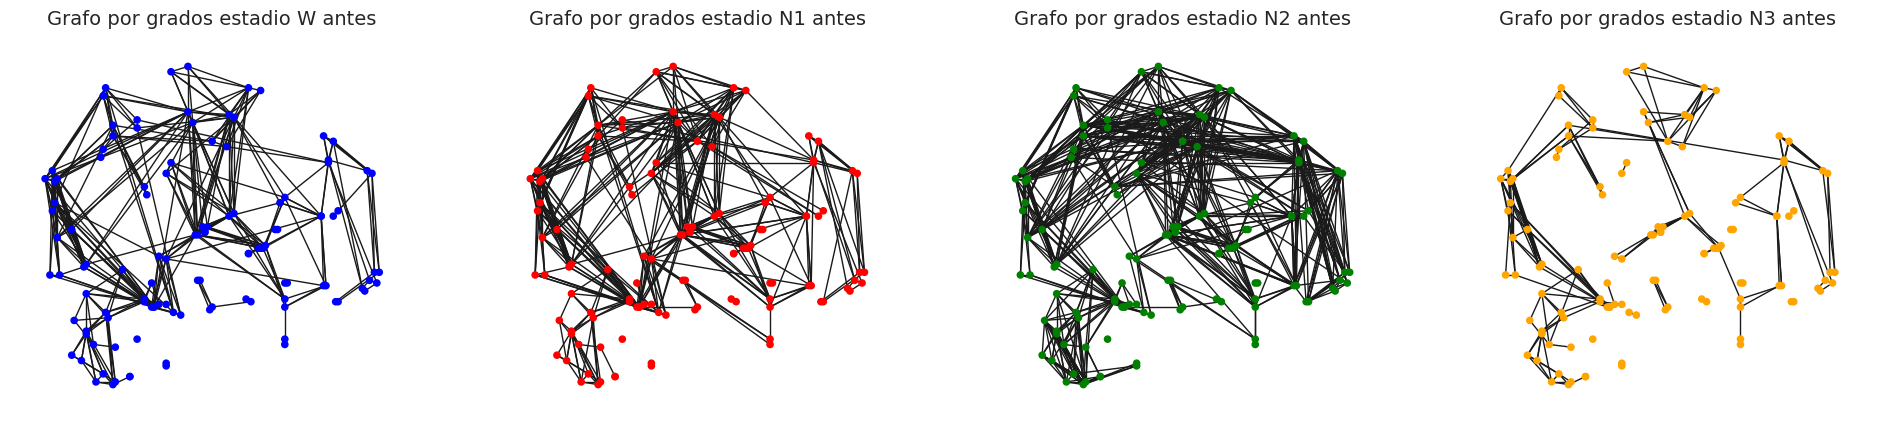

In [ ]:
densidades_antes = [0.0550, 0.0650, 0.095, 0.0300]
densidades_despues = [0.0600, 0.0700, 0.10, 0.0350]

fig, axs = plt.subplots(1, 4, figsize=(24, 5))

for i, g in enumerate(graficos):
    G_antes = binarizar_matriz(matrices[g],  densidades_antes[i])
    graficar_grafo(G_antes, g, "antes", axs[i], colores)

plt.show()

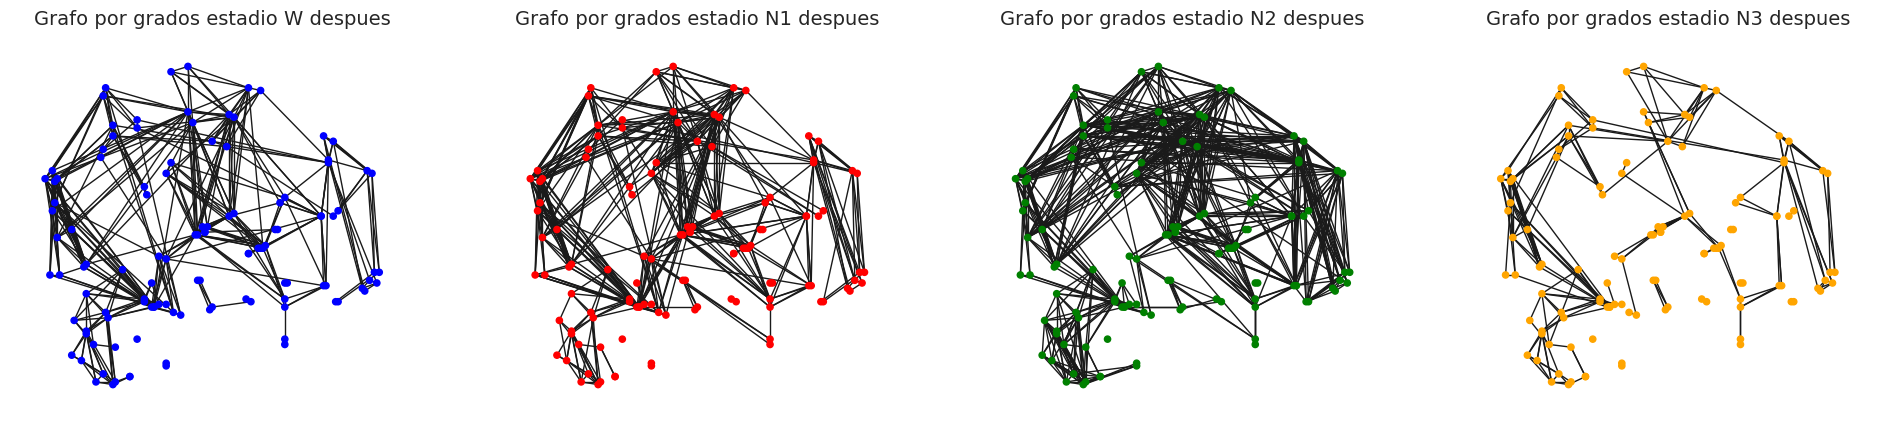

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(24, 5))

for i, g in enumerate(graficos):
    G_antes = binarizar_matriz(matrices[g],  densidades_despues[i])
    graficar_grafo(G_antes, g, "despues", axs[i], colores)

plt.show()

## Tarea 1.3

### Grado Medio


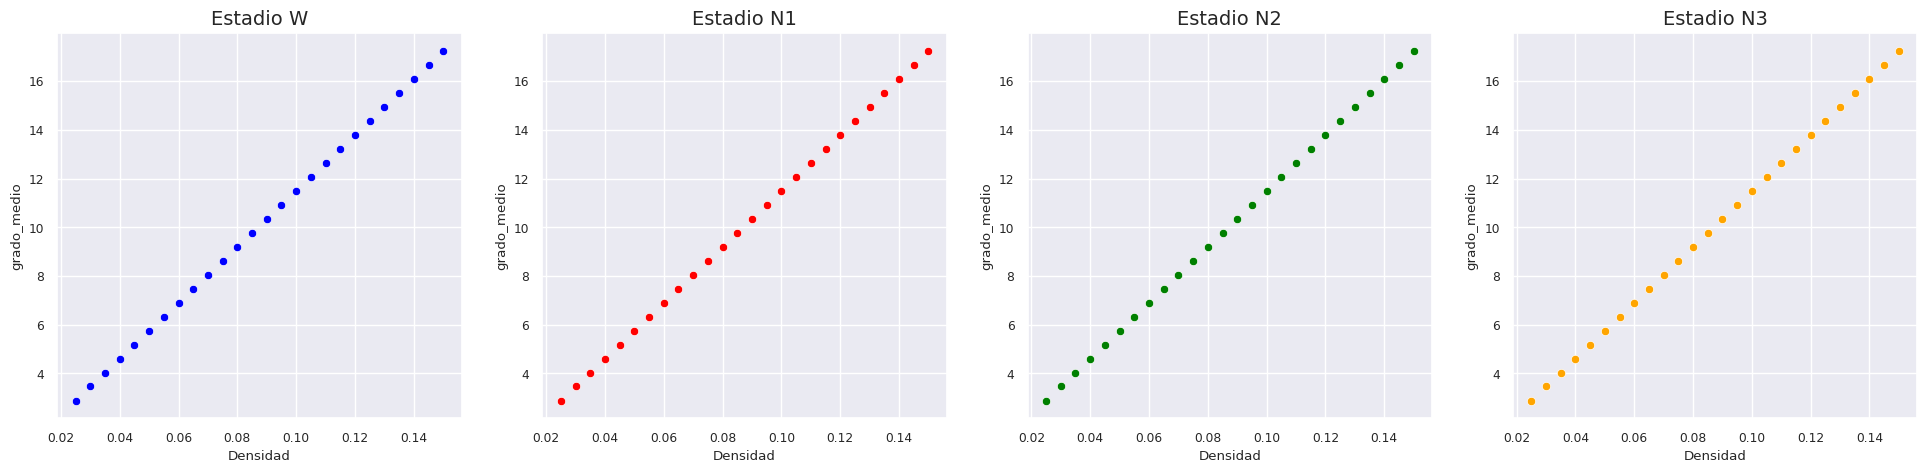

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(24, 5))

for i, g in enumerate(graficos):
  iterar_densidades_grado_medio(matrices[g],  densidades, colores, g, axs[i])

plt.show()

### Coeficiente clustering

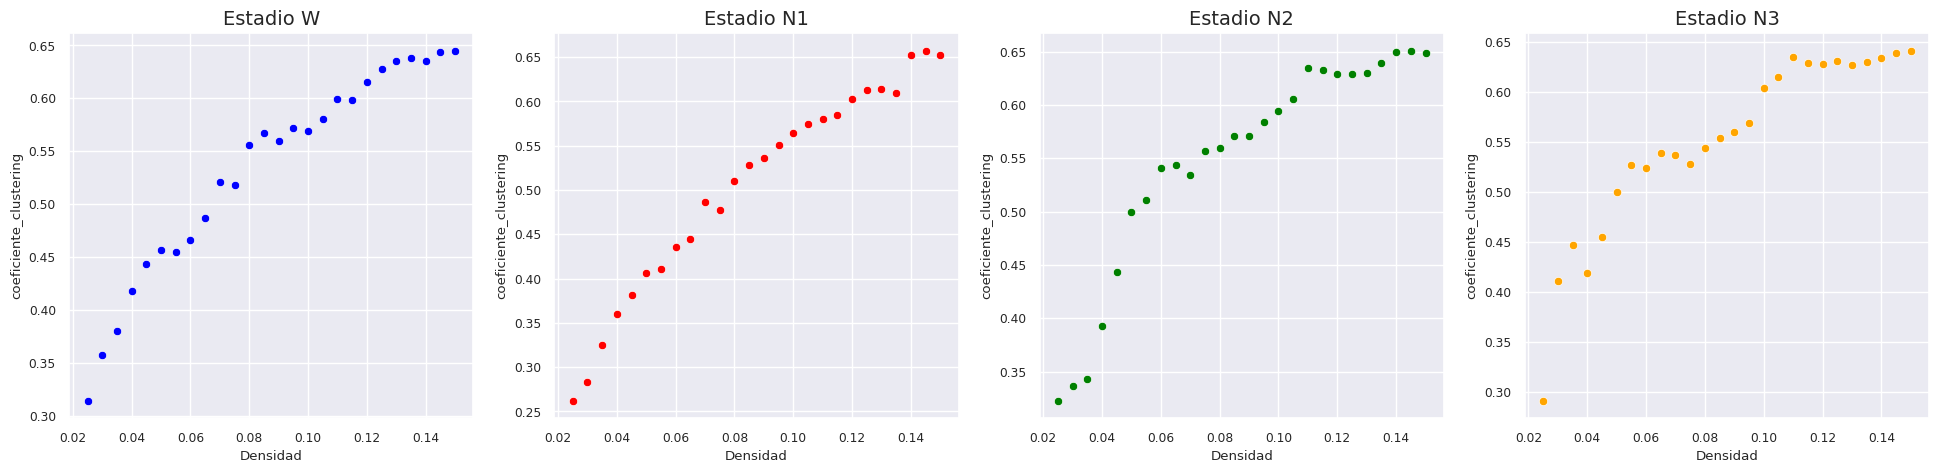

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(24, 5))

for i, g in enumerate(graficos):
  iterar_densidades_coef_clustering (matrices[g],  densidades, colores, g, axs[i])
plt.show()

### Eficiencia Global

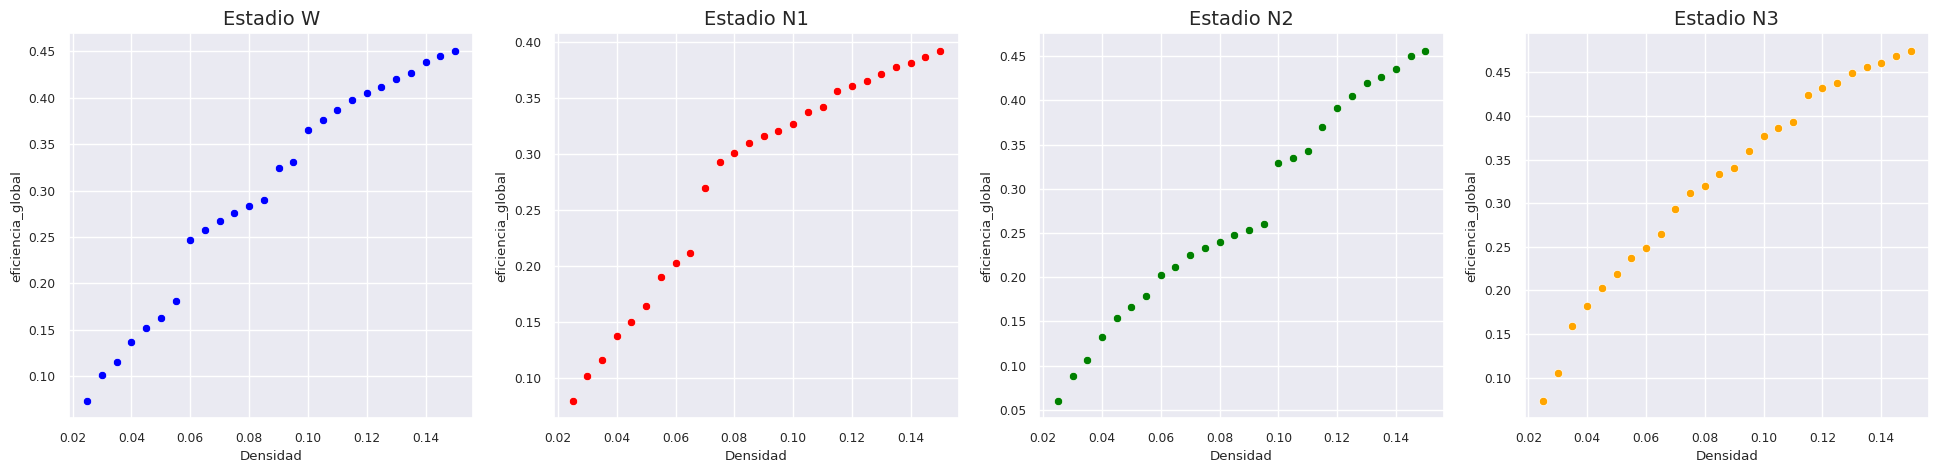

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(24, 5))

for i, g in enumerate(graficos):
  df = iterar_densidades_eficiencia_global(matrices[g],  densidades, colores, g, axs[i])

plt.show()


## Tarea 1.4

<ipython-input-861-0e74fe926291>:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10')


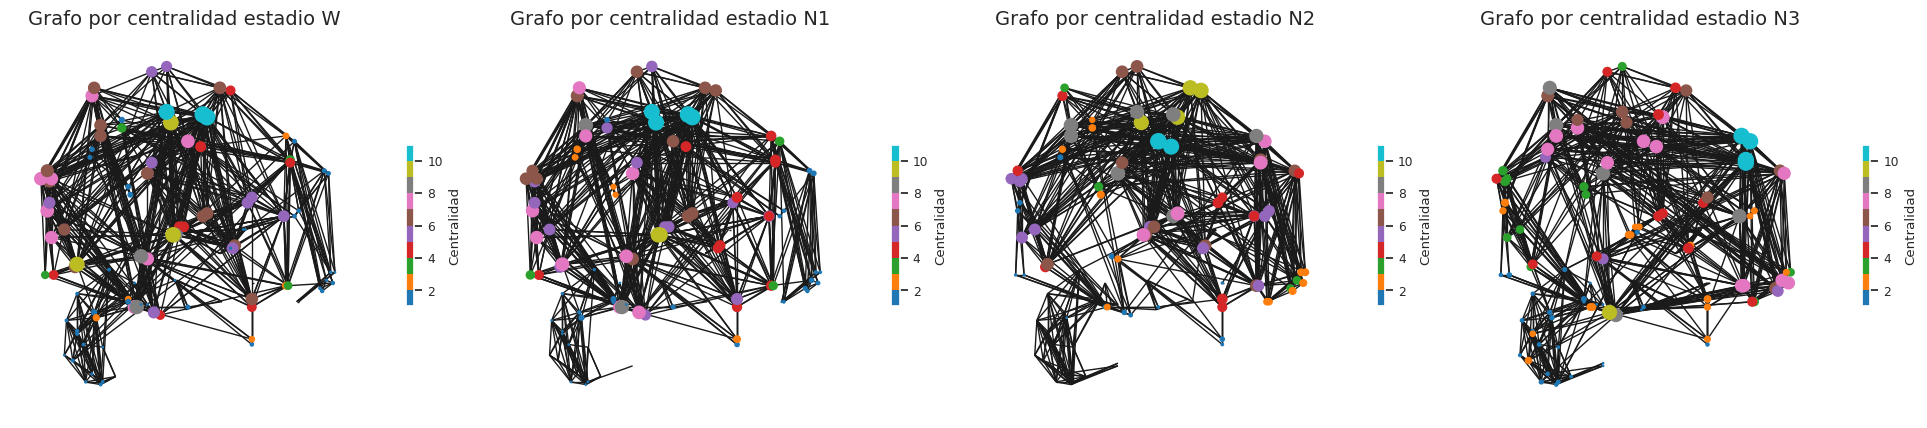

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(24, 5))

for i, g in enumerate(graficos):
    G = binarizar_matriz(matrices[g],  0.12)
    sm = graficar_grafo_por_centralidad(G, g, axs[i],"", alfa = 5)
    cbar = plt.colorbar(sm, ax=axs[i], orientation='vertical', fraction=0.02, pad=0.1)
    cbar.set_label('Centralidad')  # Puedes personalizar la etiqueta según sea necesario


plt.show()

# Tarea 2: Comunidades y coeficiente de modularidad

## Tarea 2.1

Para cada sujeto de cada estadío generar grafos variando δ, determinar comunidades en dichos grafos a partir de algoritmo de Louvain [Blondel et al., 2008], y calcular la curva que describa el coeficiente de modularidad (Q) en función de δ. Promediando entre sujetos de cada estadío, obtener la curva correspondiente a cada estadío. Compararlas con las curvas de Q en función de δ para “modelos nulos” equivalentes: usando grafos random de igual cantidad total de nodos e igual densidad de enlaces δ. Para cada valor 2 de δ incluir un test de significancia clásico para diferencias entre el grafo observado y el modelo nulo de grafo azar (marcar con un asterico las comparciones significativas).
Discutir los resultados

In [ ]:


def calcular_modularidad(m_ady, d):

    #Matriz
    G = binarizar_matriz(m_ady, d)
    partition = community.best_partition(G, random_state=42)
    modularidad = community.modularity(partition, G)
    comunidades = len(set(partition.values()))


    return G, modularidad, comunidades, partition

def generar_grafos_random(repetitions, nodos, ejes):

  modularity_random = 0
  modularidades_random = []

  for i in range(repetitions):
    G_random = nx.gnm_random_graph(nodos,ejes)
    partition_random = community.best_partition(G_random)

    modularidad = community.modularity(partition_random, G_random)
    modularity_random = modularity_random + modularidad / repetitions
    modularidades_random.append(modularidad)
    comunidades = len(set(partition_random.values()))

  return G_random, modularity_random, comunidades, modularidades_random

In [ ]:

#Dada una lista de filanemes de un estadio, y el tipo de estadio
#devuelve un dataframw con todos las modularidades por densidad
#tambien calcula arboles random segun cantidad de ejes y nodos

def calcular_metricas_estadios(filenames, estadios = {'W'}, incluir_random = True):
  #Modularidades de sujetos en estadio W
  modularidades = []

  for e in estadios:

    for filename in filenames[e]:

      m = calcular_matriz(filename)

      for d in densidades:
          #genera el grafo para el sujeto, estadio
          G, modularity, comunidades, _ = calcular_modularidad(m, d)
          nodos, ejes = G.number_of_nodes(), G.number_of_edges()
          modularidades.append((filename, e, d, modularity, nodos, ejes, comunidades ))

          if incluir_random:
            #genera su contraparte Random
            G_random, modularity_random, comunidades_random, modularidades_random = generar_grafos_random(1, nodos, ejes )
            modularidades.append((filename, 'R', d, modularity_random, G_random.number_of_nodes(), G_random.number_of_edges(),comunidades_random ))

  df_modularidades = pd.DataFrame(modularidades, columns=['filename', 'estadio', 'densidad', 'modularidad', 'nodos', 'ejes', 'comunidades'])

  return (df_modularidades)

In [ ]:

def calcular_sem_por_densidad(df_modularidades,  metrica = 'modularidad'):

  grupos_densidad = df_modularidades.groupby('densidad')[metrica]
  sem_por_densidad = pd.DataFrame(grupos_densidad.apply(sem)).to_numpy().flatten()

  return sem_por_densidad

def zzz_deprecada_graficar_curva_modularidad_zzz(df_modularidades, estadio, color):

  promedio_modularidad = df_modularidades.groupby('densidad')['modularidad'].mean().reset_index()

  sem_por_densidad = calcular_sem_por_densidad(df_modularidades)

  fig, ax = plt.subplots()  # Crear la figura y los ejes
  sns.lineplot(x = 'densidad', y = 'modularidad', data = promedio_modularidad, label=f'Modularidad {estadio}', marker='o', color=color, ax=ax)

  # Agregar barras de error
  # lo multiplico por 3 para que se vea nada mas. Hay que ver si estoy haciendo bien los calculos
  ax.errorbar(promedio_modularidad['densidad'], promedio_modularidad['modularidad'], yerr = sem_por_densidad, fmt='-s', color=color)

  plt.show()

  return fig, ax



In [ ]:
def calcular_significancia(modularidades_estadio, modularidades_random):

  t_stat, p_valor_t = ttest_ind(modularidades_estadio, modularidades_random)

  return t_stat, p_valor_t


In [ ]:
def graficar_metrica_estadio_vs_random(filenames, estadios, estadio, colores, ax, metrica = 'modularidad', y_significatividad = 0.15, p_valor = 0.05):


  df_metricas = calcular_metricas_estadios(filenames, set(estadios) - {'R'}, incluir_random = 'R' in  estadios)


  for e in estadios:
    df_metricas_w = df_metricas.loc[df_metricas['estadio'] == e]

    #Obtengo los datos que voy a necesitar para graficar W
    promedio_metrica = df_metricas_w.groupby('densidad')[metrica].mean().reset_index()
    sem_por_densidad = calcular_sem_por_densidad(df_metricas_w, metrica)

    #grafico W
    ax = sns.lineplot(x = 'densidad', y = metrica, data = promedio_metrica, label=f'{metrica} {e}', marker='o', color = colores[e], ax=ax)
    ax.errorbar(promedio_metrica['densidad'], promedio_metrica[metrica], yerr = sem_por_densidad, fmt='-s', color = colores[e])

  p_valor_t = 1

  for d in densidades:

    #filtro por la densidad
    mask_e = (df_metricas['estadio'] == estadios[0]) & (df_metricas['densidad'] == d)
    df_mod_est_d = df_metricas.loc[mask_e]

    mask_r = (df_metricas['estadio'] == estadios[1]) & (df_metricas['densidad'] == d)
    df_mod_rnd_d = df_metricas.loc[mask_r]

    #calculo el estadistico
    t_stat, p_valor_t = calcular_significancia(df_mod_est_d[metrica], df_mod_rnd_d[metrica])
    if p_valor_t < p_valor:
      ax.text(d, y_significatividad, '*', color = 'black', fontsize = 10)  # 's' controla el tamaño del marcador

  ax.set_title(f'Estadio {estadios[0]} comparado con {estadios[1]}', fontsize=14)


  return df_metricas



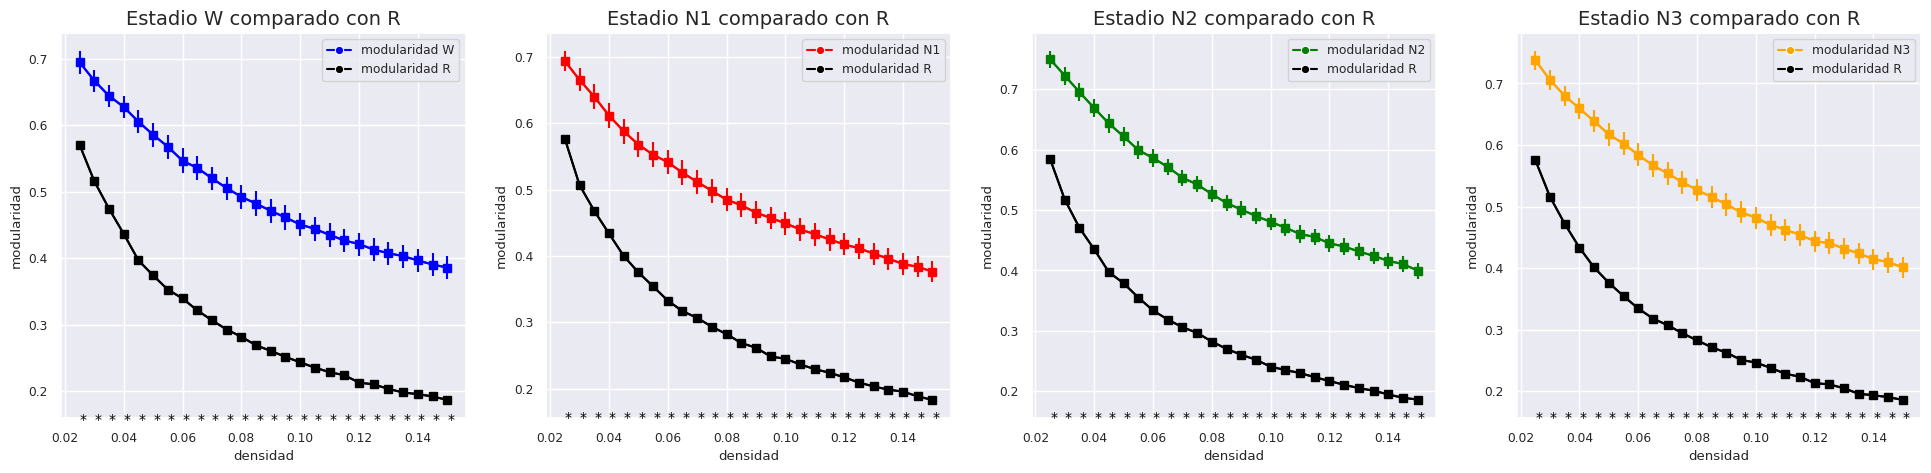

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(24, 5))
estadios = {'W': ['W', 'R'], 'N1': ['N1','R'], 'N2': ['N2','R'], 'N3': ['N3','R']}


for i, g in enumerate(graficos):
  df_m = graficar_metrica_estadio_vs_random(filenames_todos, estadios[g], g, colores, axs[i], 'modularidad')

plt.show()




## Tarea 2.2

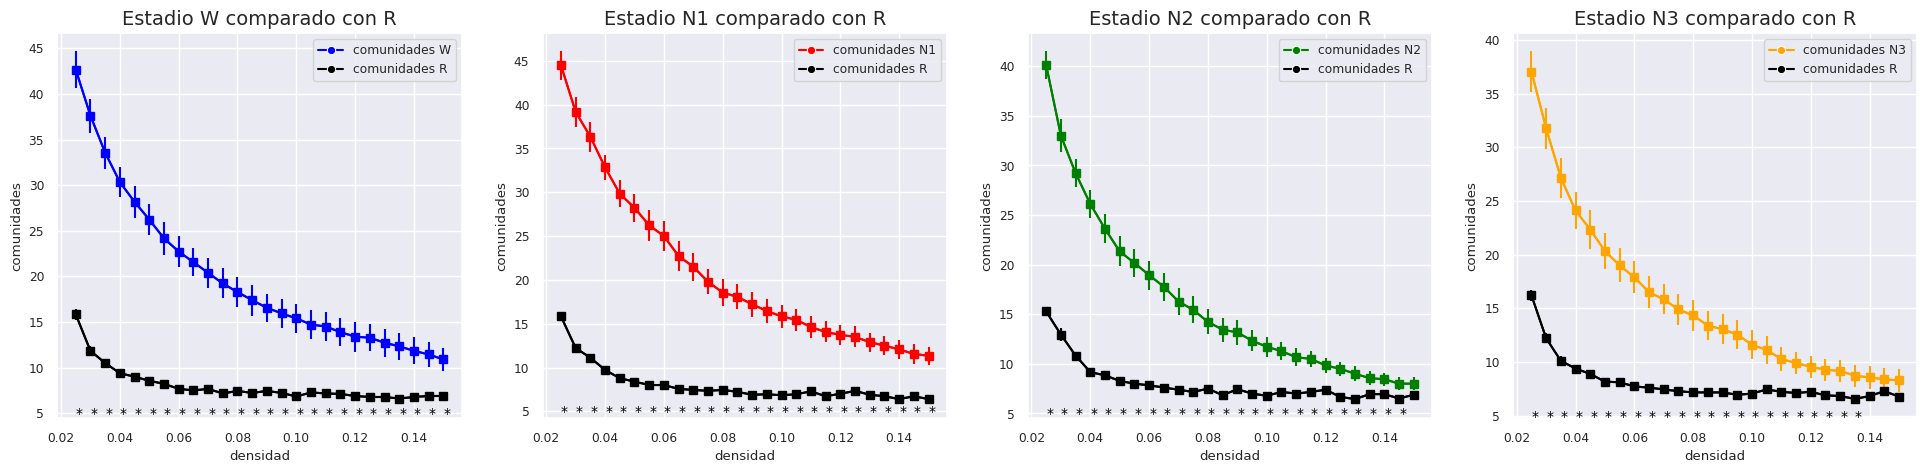

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(24, 5))
estadios = {'W': ['W', 'R'], 'N1': ['N1','R'], 'N2': ['N2','R'], 'N3': ['N3','R']}


for i, g in enumerate(graficos):
  df_m = graficar_metrica_estadio_vs_random(filenames_todos, estadios[g], g, colores, axs[i], 'comunidades', y_significatividad = 4.5)

plt.show()

## Tarea 2.3

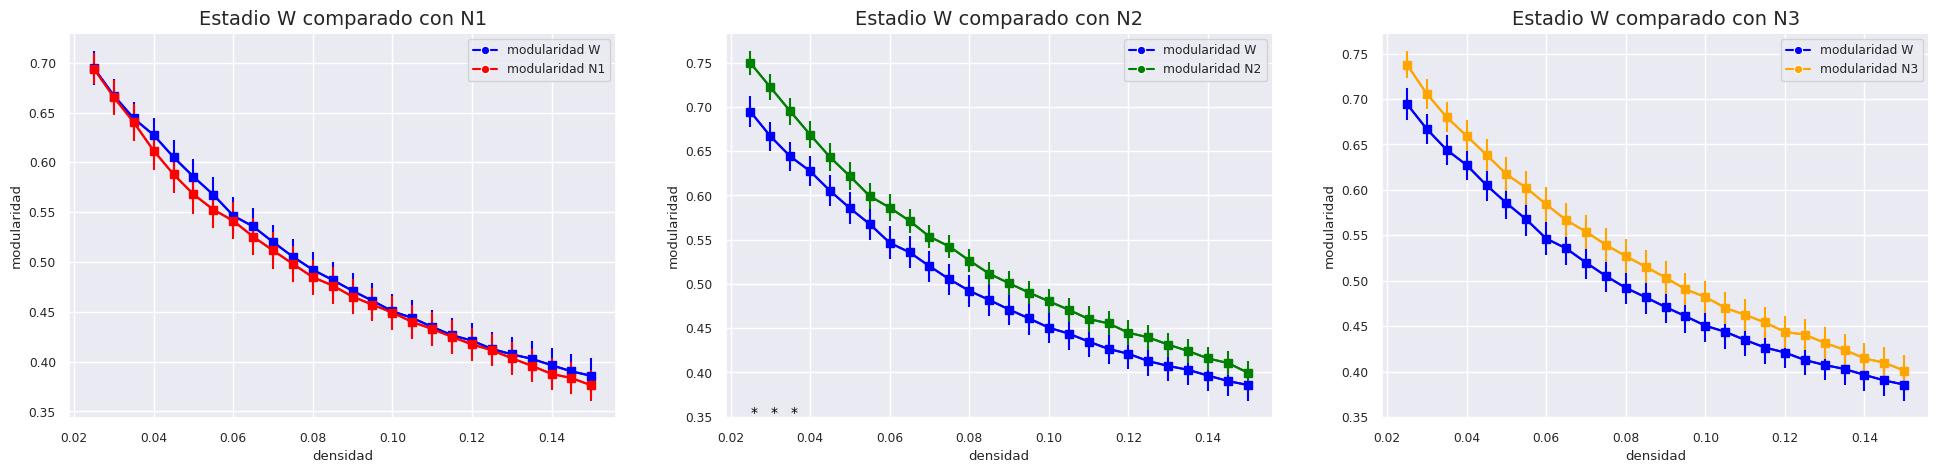

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(24, 5))
estadios = [['W', 'N1'], ['W','N2'], ['W','N3']]

for i, g in enumerate(estadios):
  df_m = graficar_metrica_estadio_vs_random(filenames_todos, g, g[0], colores, axs[i], 'modularidad', y_significatividad = 0.35)

plt.show()

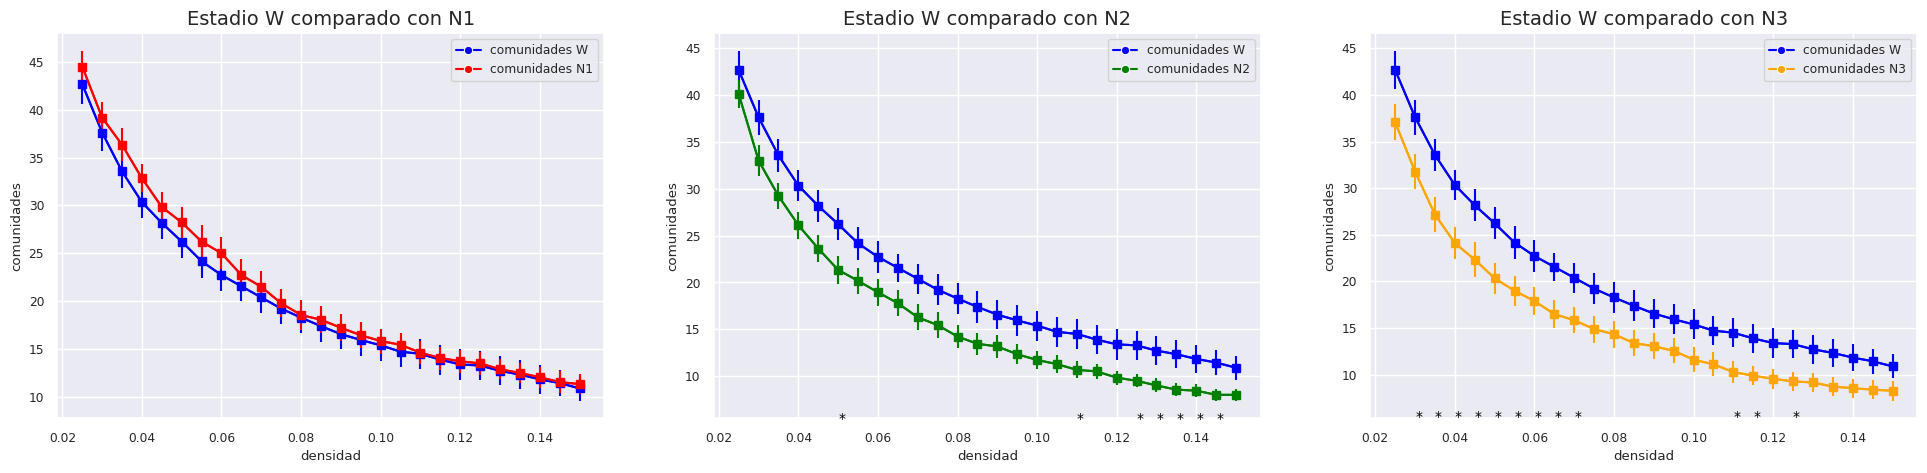

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(24, 5))
estadios = [['W', 'N1'], ['W','N2'], ['W','N3']]

for i, g in enumerate(estadios):
  df_m = graficar_metrica_estadio_vs_random(filenames_todos, g, g[0], colores, axs[i], 'comunidades', y_significatividad = 5)

plt.show()


## Tarea 2.4

In [ ]:
def iterar_densidades_modularidad(m_ady, densidades, titulo_1 = "", metrica = 'modularidad'):

  modularidades = []

  for d in densidades:
    #Matriz W
    G, modularity, comunidades, _  = calcular_modularidad(m_ady, d)
    modularidades.append((d, modularity, comunidades))

  df_resultados = pd.DataFrame(modularidades, columns=['densidad', 'modularidad', 'comunidades'])

  sns.lineplot(x='densidad', y=metrica, data=df_resultados, label= f'{metrica} {titulo_1}', marker='o', color='blue')
  plt.errorbar(df_resultados['densidad'], df_resultados[metrica],  fmt='-s', color='blue')
  return(df_resultados)

### Estadio W

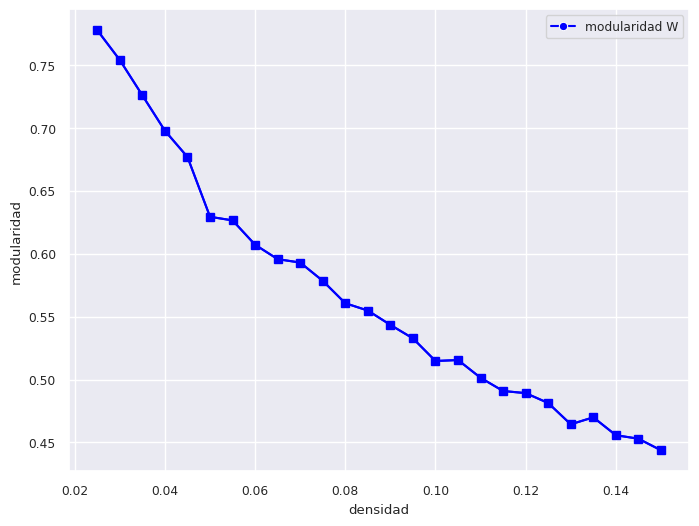

In [ ]:
ady_w = promediar_matrices(filenames_w)
a = iterar_densidades_modularidad(ady_w, densidades, "W")


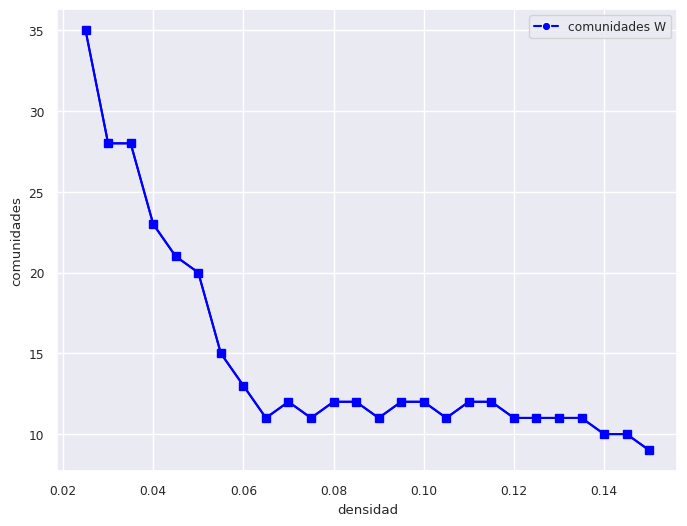

In [ ]:
ady_w = promediar_matrices(filenames_w)
a = iterar_densidades_modularidad(ady_w, densidades, "W", metrica = 'comunidades')


### Estadio N1

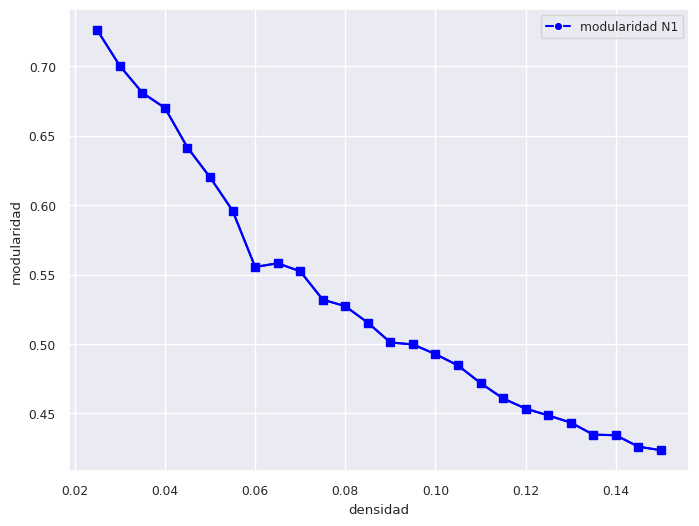

In [ ]:
ady_n1 = promediar_matrices(filenames_n1)
a = iterar_densidades_modularidad(ady_n1, densidades, "N1")


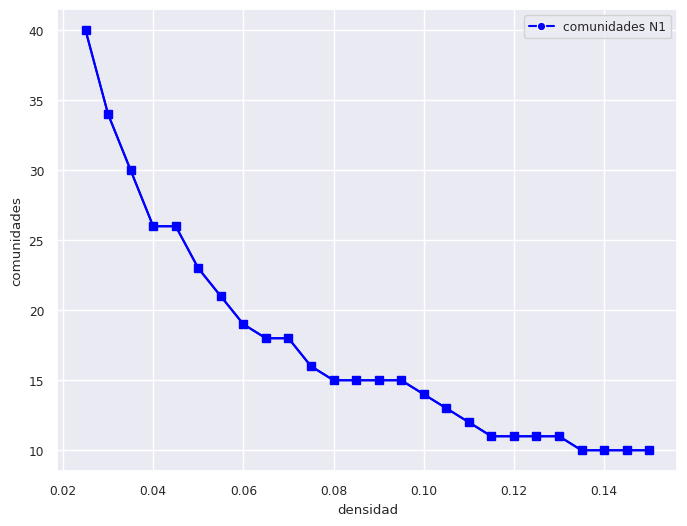

In [ ]:
ady_n1 = promediar_matrices(filenames_n1)
a = iterar_densidades_modularidad(ady_n1, densidades, "N1", metrica = 'comunidades')


### Estadio N2

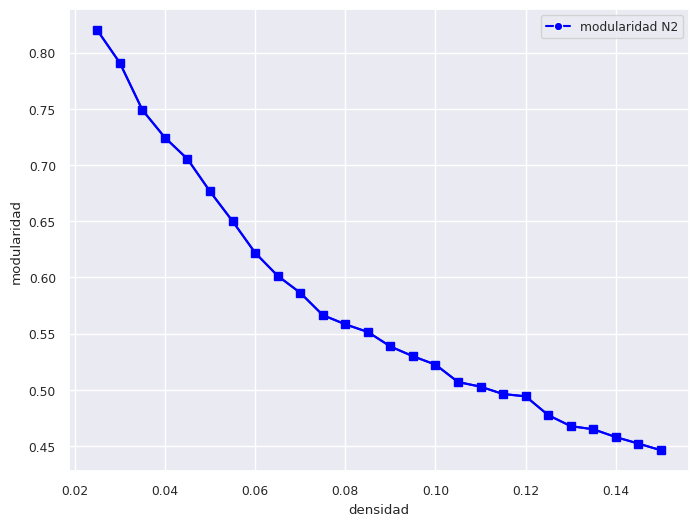

In [ ]:
ady_n2 = promediar_matrices(filenames_n2)
a = iterar_densidades_modularidad(ady_n2, densidades, "N2")


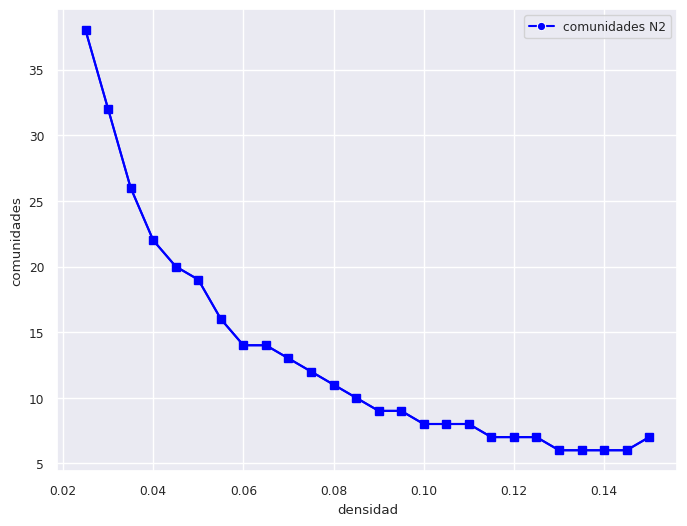

In [ ]:
ady_n2 = promediar_matrices(filenames_n2)
a = iterar_densidades_modularidad(ady_n2, densidades, "N2", metrica = 'comunidades')


### Estadio N3

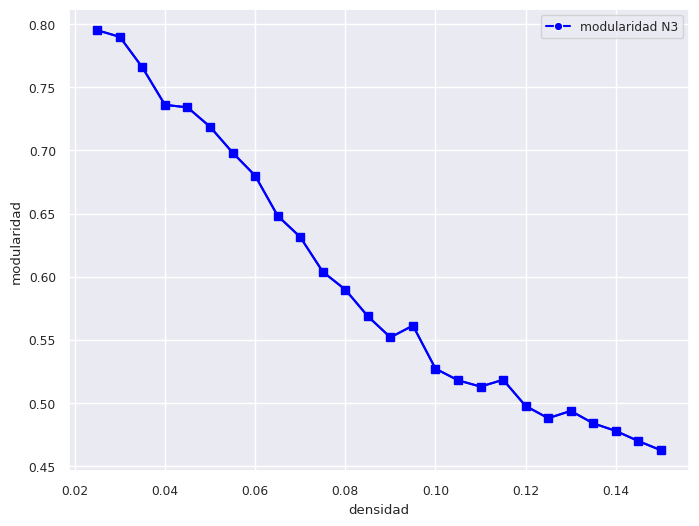

In [ ]:
ady_n3 = promediar_matrices(filenames_n3)
a = iterar_densidades_modularidad(ady_n3, densidades, "N3")


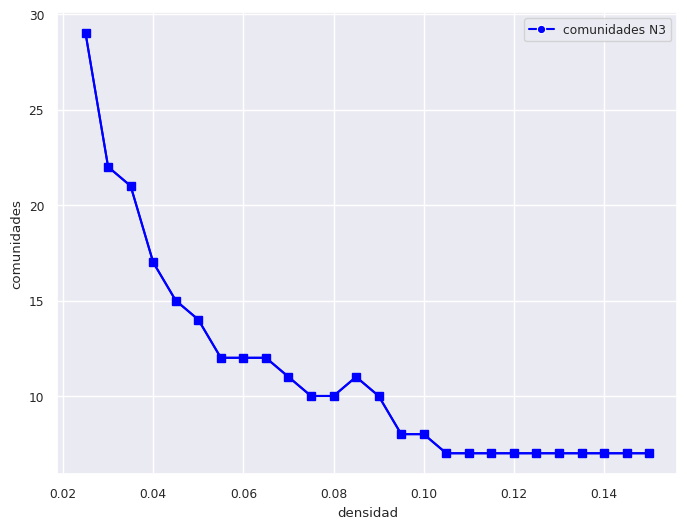

In [ ]:
ady_n3 = promediar_matrices(filenames_n3)
a = iterar_densidades_modularidad(ady_n3, densidades, "N3", metrica = 'comunidades')


In [ ]:
densidad_interesante = 0.035

G, modularity, comunidades, particion = calcular_modularidad(ady_n3, densidad_interesante)


In [ ]:

def get_partition_from_girvan_gewman(G, lev = 1):

  random_state = 42  # Puedes elegir cualquier número como semilla
  random.seed(random_state)

  communities = gn.girvan_newman(G)

  for _ in itertools.islice(communities, lev - 1):
      pass

  # Obtener la k-ésima partición
  communities_k = next(communities)

  # Crear un diccionario de nodos y comunidades
  node_community_dict = {node: community_id for community_id, community in enumerate(communities_k) for node in community}

  return node_community_dict



def graficar_grafo_por_comunidades(G, estadio, ax, colores, method = 'louvain', lev = 1):

  parition = {}

  if method == 'louvain':
    partition = community.best_partition(G, random_state= 42)
  else:
    partition = get_partition_from_girvan_gewman(G, lev = lev)

  communities = set(partition.values())
  num_communities = len(communities)

  unique_labels = list(communities)
  label_to_number = {label: i + 1 for i, label in enumerate(unique_labels)}
  num_labels = len(unique_labels)


  cm = generar_lista_colores(num_labels)
  node_color = [cm[partition[node]] for node in G.nodes()]

  n_size = 150  # tamaño de nodos constante

  ax.set_title(f'Grafo por comunidades {estadio} ({method})', fontsize=14)

  layout = dict(zip(range(116), np.array([RegionsNames[6].values, RegionsNames[7].values]).T))
  node_labels = {n: str(n) for n in G.nodes()}  # crea diccionario con número de nodo como label

  nx.draw(G, layout, node_size=n_size, node_color=node_color, labels=node_labels, ax=ax)

  handles = []
  for i, label in enumerate(unique_labels):
      handle = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cm[label], markersize=10, label=label)
      handles.append(handle)

  ax.legend(handles=handles, title='communities', loc='upper left', bbox_to_anchor=(1, 1))
  return partition

In [ ]:


def generar_lista_colores(n):
  catalogo_colores = {0:'blue', 1:'orange', 2:'green', 3:'red', 4:'purple',
            5:'pink', 6:'gray', 7:'olive', 8:'aqua', 9:'chartreuse',
            10:'darksalmon', 11:'darkslategrey', 12:'deeppink', 13:'fuchsia', 14:'indigo',
            15:'lightsteelblue', 16:'lime', 17:'mediumturquoise', 18:'powderblue', 19:'yellow',
            20:'wheat', 21:'cyan'}

  return dict(islice(catalogo_colores.items(), n))


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


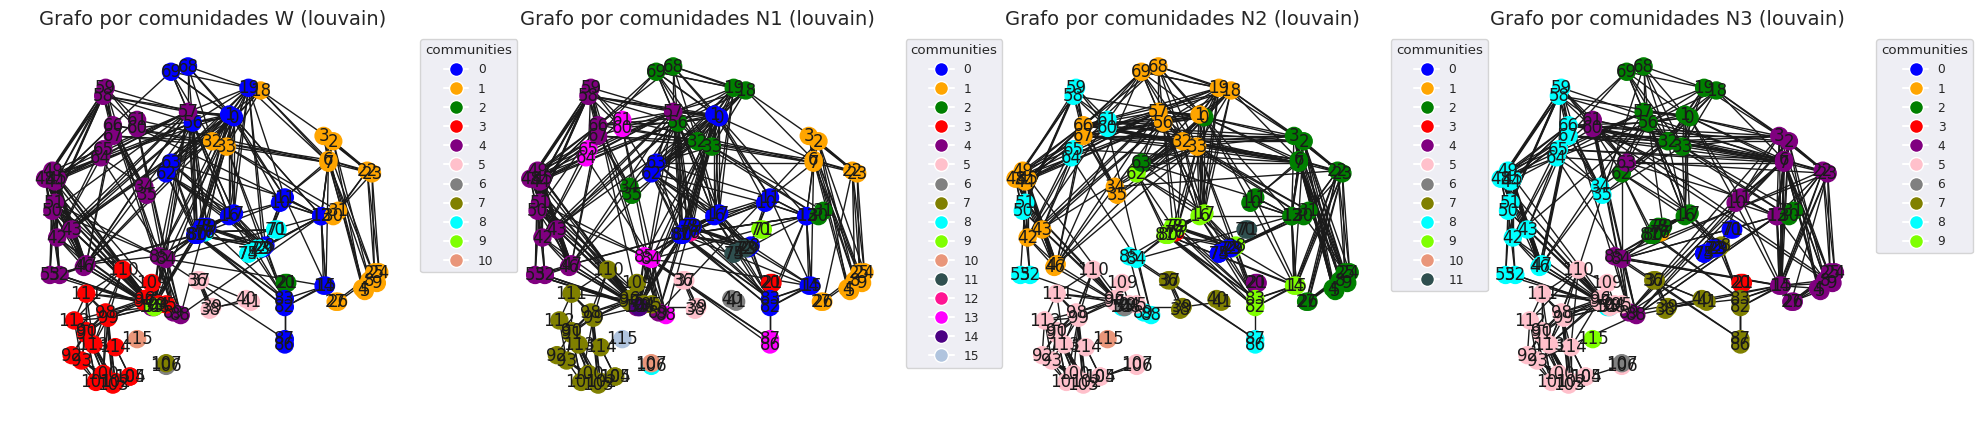

In [ ]:

densidades_interesantes = [0.12, 0.12, 0.12, 0.12]
#densidades_interesantes = [0.06, 0.06, 0.06, 0.06]
densidades_interesantes = [0.09, 0.09, 0.09, 0.09]
densidades_interesantes = [0.075, 0.075, 0.075, 0.075]

fig, axs = plt.subplots(1, 4, figsize=(24, 5))

for i, g in enumerate(graficos):
    G = binarizar_matriz(matrices[g],  densidades_interesantes[i])
    #graficar_grafo(G, g, "antes", axs[i], colores)
    partition = graficar_grafo_por_comunidades(G, g, axs[i], colores)
    #partition = community.best_partition(G, random_state=42)
    print (set(partition.values()))

plt.show()


## Tarea 2.5 (Opcional 1)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


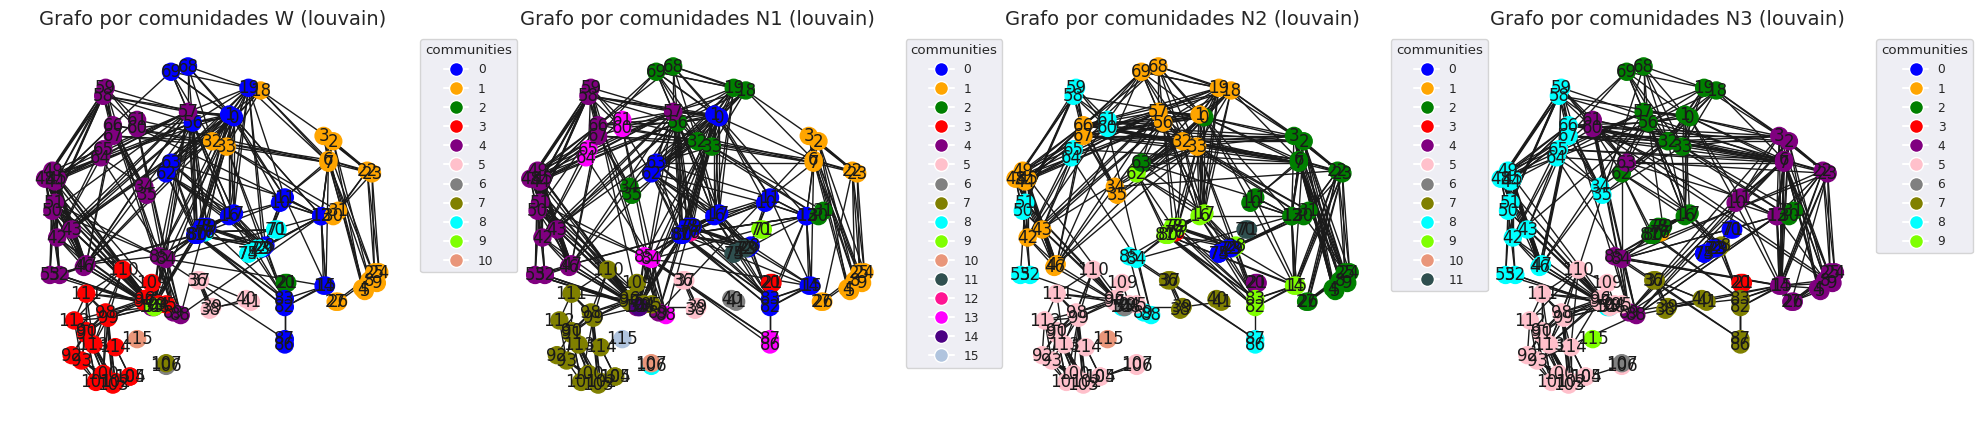

In [ ]:
#Louvain

fig, axs = plt.subplots(1, 4, figsize=(24, 5))

for i, g in enumerate(graficos):
    G = binarizar_matriz(matrices[g],  densidades_interesantes[i])
    #graficar_grafo(G, g, "antes", axs[i], colores)
    partition = graficar_grafo_por_comunidades(G, g, axs[i], colores)
    #partition = community.best_partition(G, random_state=42)
    print (set(partition.values()))

plt.show()

{0, 1, 2, 3, 4, 5, 6, 7, 8}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}
{0, 1, 2, 3, 4, 5, 6, 7, 8}
{0, 1, 2, 3, 4, 5, 6}


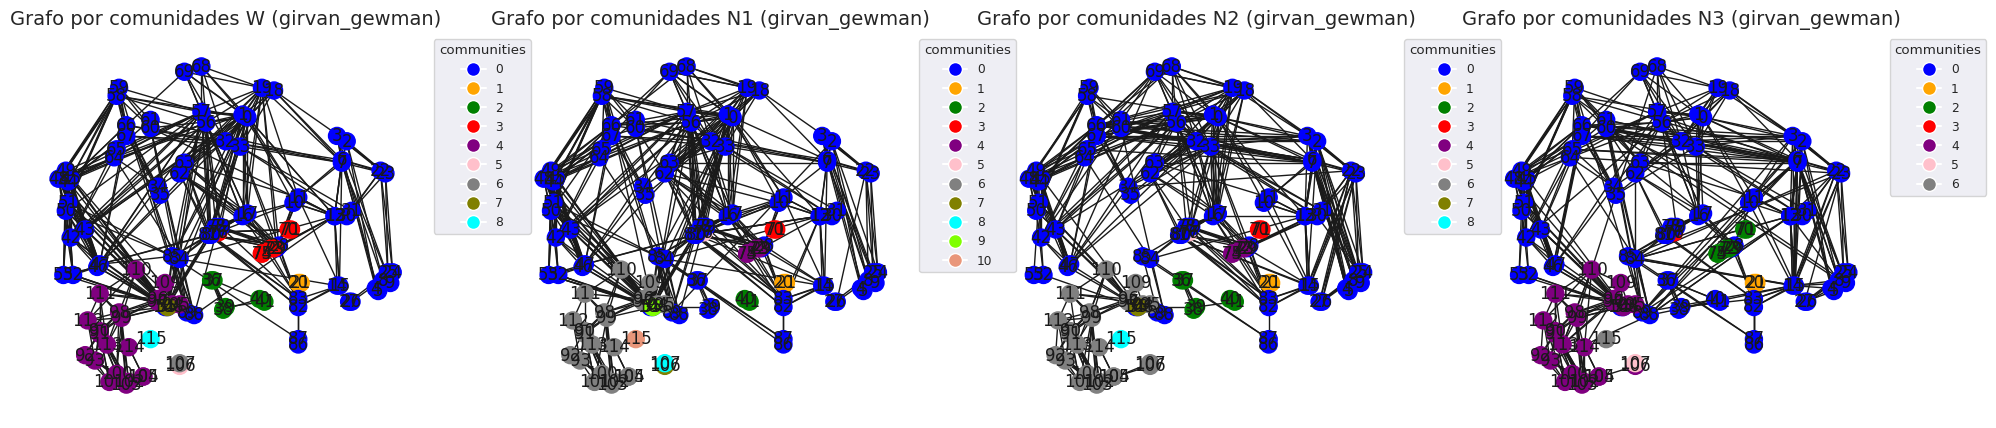

In [ ]:
#girvan_gewman
fig, axs = plt.subplots(1, 4, figsize=(24, 5))

for i, g in enumerate(graficos):
    G = binarizar_matriz(matrices[g],  densidades_interesantes[i])
    #graficar_grafo(G, g, "antes", axs[i], colores)
    partition = graficar_grafo_por_comunidades(G, g, axs[i], colores,method = 'girvan_gewman', lev = 1)
    print (set(partition.values()))

plt.show()

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}
{0, 1, 2, 3, 4, 5, 6, 7, 8}


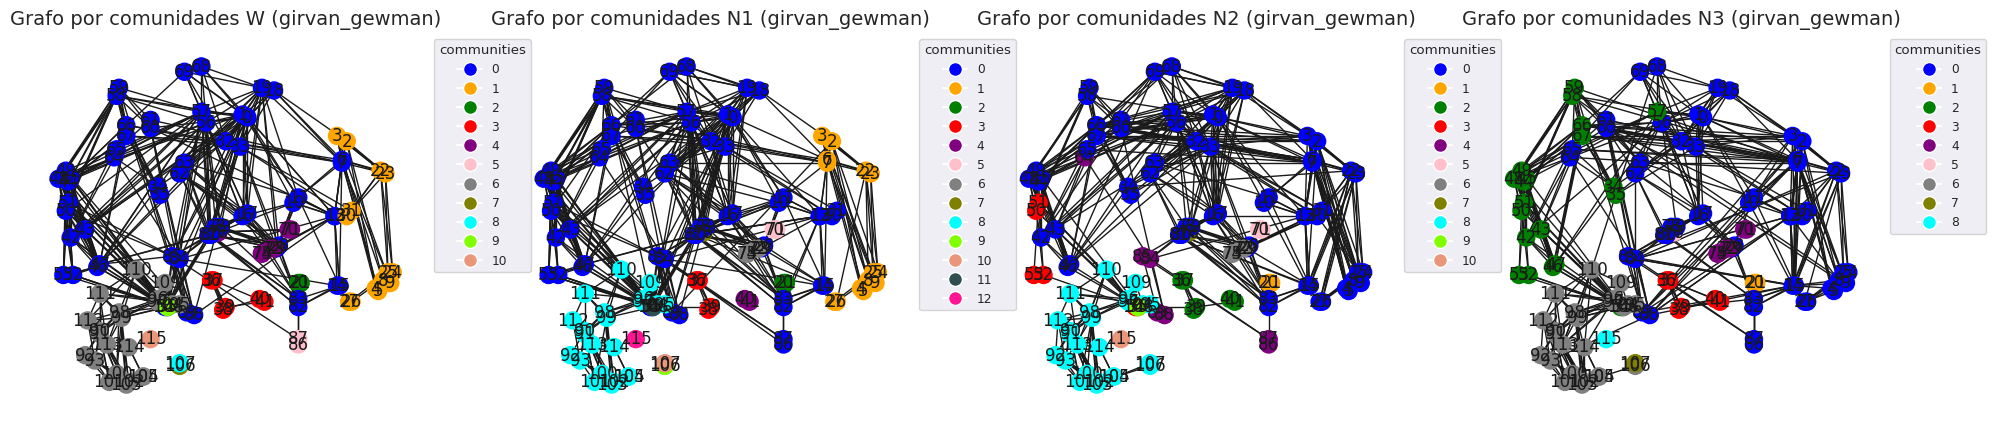

In [ ]:
#girvan_gewman
fig, axs = plt.subplots(1, 4, figsize=(24, 5))

for i, g in enumerate(graficos):
    G = binarizar_matriz(matrices[g],  densidades_interesantes[i])
    #graficar_grafo(G, g, "antes", axs[i], colores)
    partition = graficar_grafo_por_comunidades(G, g, axs[i], colores,method = 'girvan_gewman', lev = 3)
    print (set(partition.values()))

plt.show()


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}


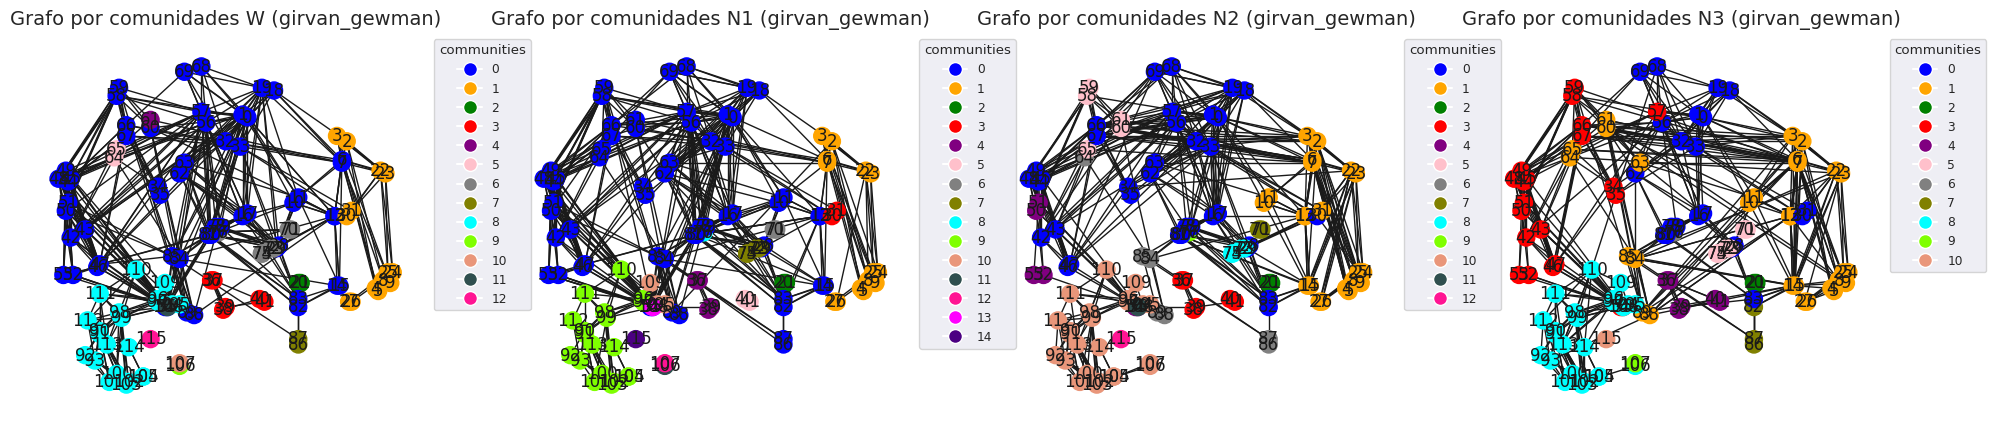

In [ ]:
#girvan_gewman
fig, axs = plt.subplots(1, 4, figsize=(24, 5))

for i, g in enumerate(graficos):
    G = binarizar_matriz(matrices[g],  densidades_interesantes[i])
    #graficar_grafo(G, g, "antes", axs[i], colores)
    partition = graficar_grafo_por_comunidades(G, g, axs[i], colores,method = 'girvan_gewman', lev = 5)
    print (set(partition.values()))

plt.show()

## Tarea 2.6 (Opcional 2)

##2.6.1

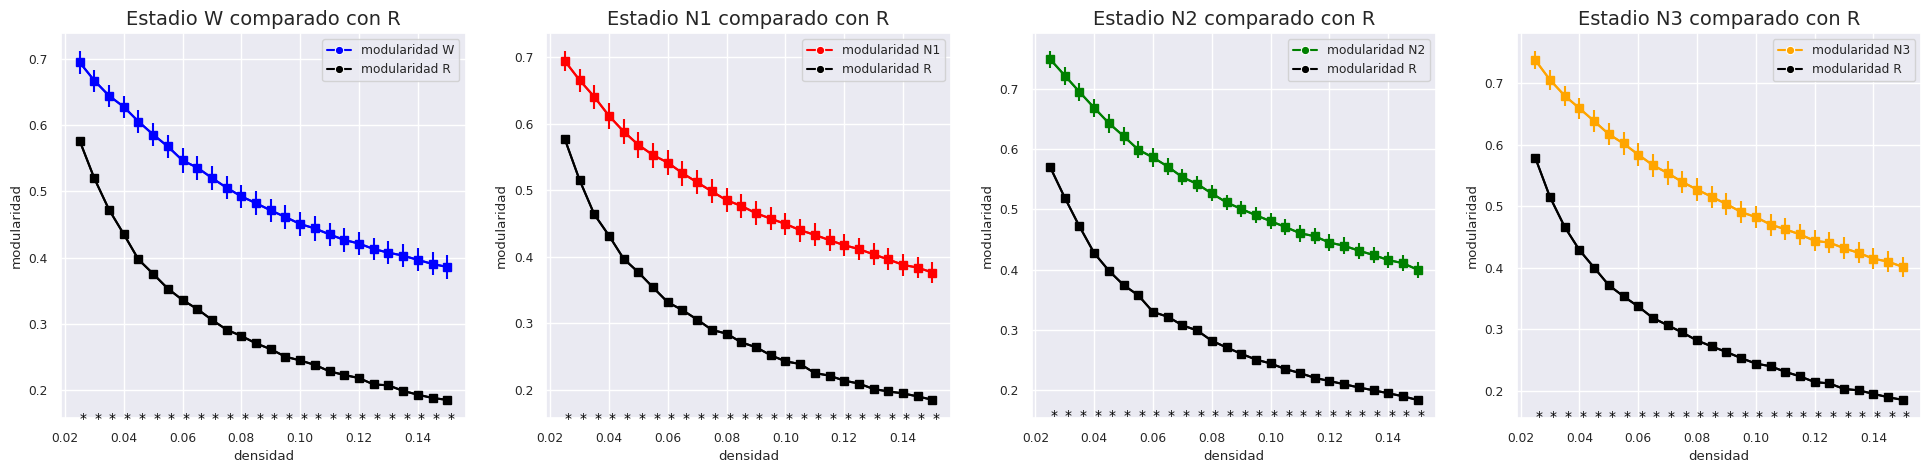

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(24, 5))
estadios = {'W': ['W', 'R'], 'N1': ['N1','R'], 'N2': ['N2','R'], 'N3': ['N3','R']}

p_valor_ajustado = 0.05 / 26

for i, g in enumerate(graficos):
  df_m = graficar_metrica_estadio_vs_random(filenames_todos, estadios[g], g, colores, axs[i], 'modularidad', p_valor = p_valor_ajustado)

plt.show()




##2.6.2

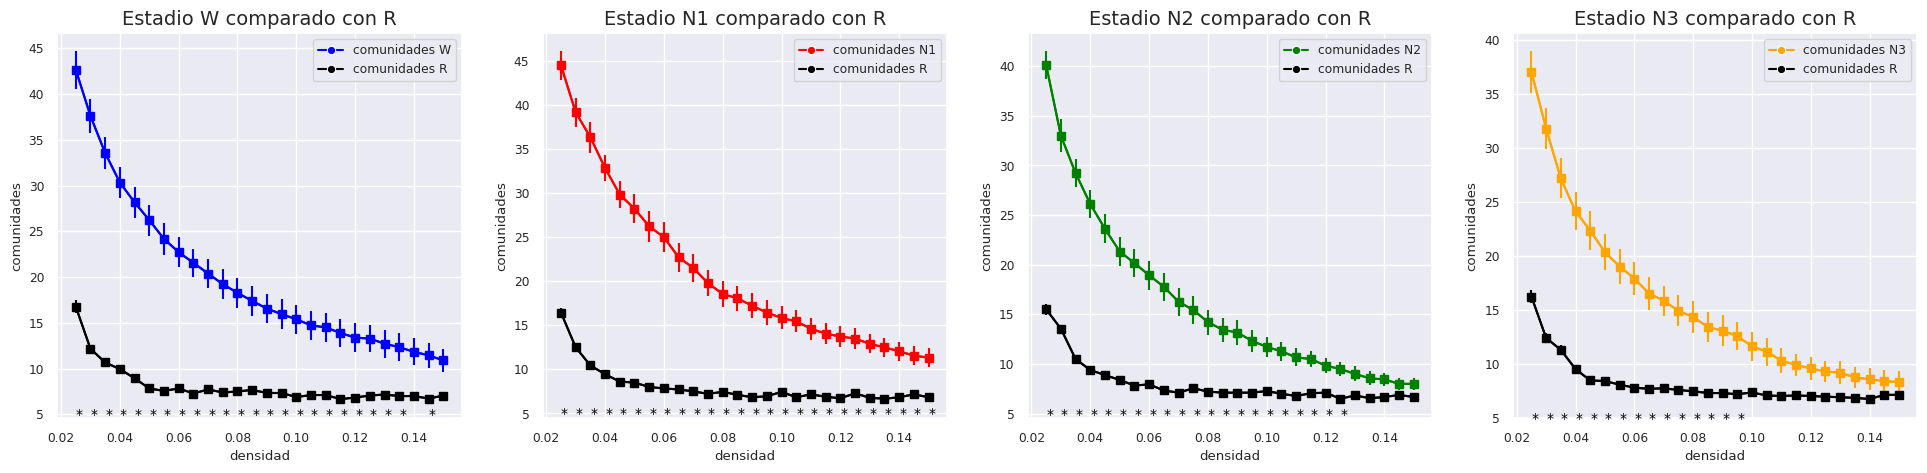

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(24, 5))
estadios = {'W': ['W', 'R'], 'N1': ['N1','R'], 'N2': ['N2','R'], 'N3': ['N3','R']}


for i, g in enumerate(graficos):
  df_m = graficar_metrica_estadio_vs_random(filenames_todos, estadios[g], g, colores, axs[i], 'comunidades', y_significatividad = 4.5, p_valor = p_valor_ajustado)

plt.show()

##2.6.3

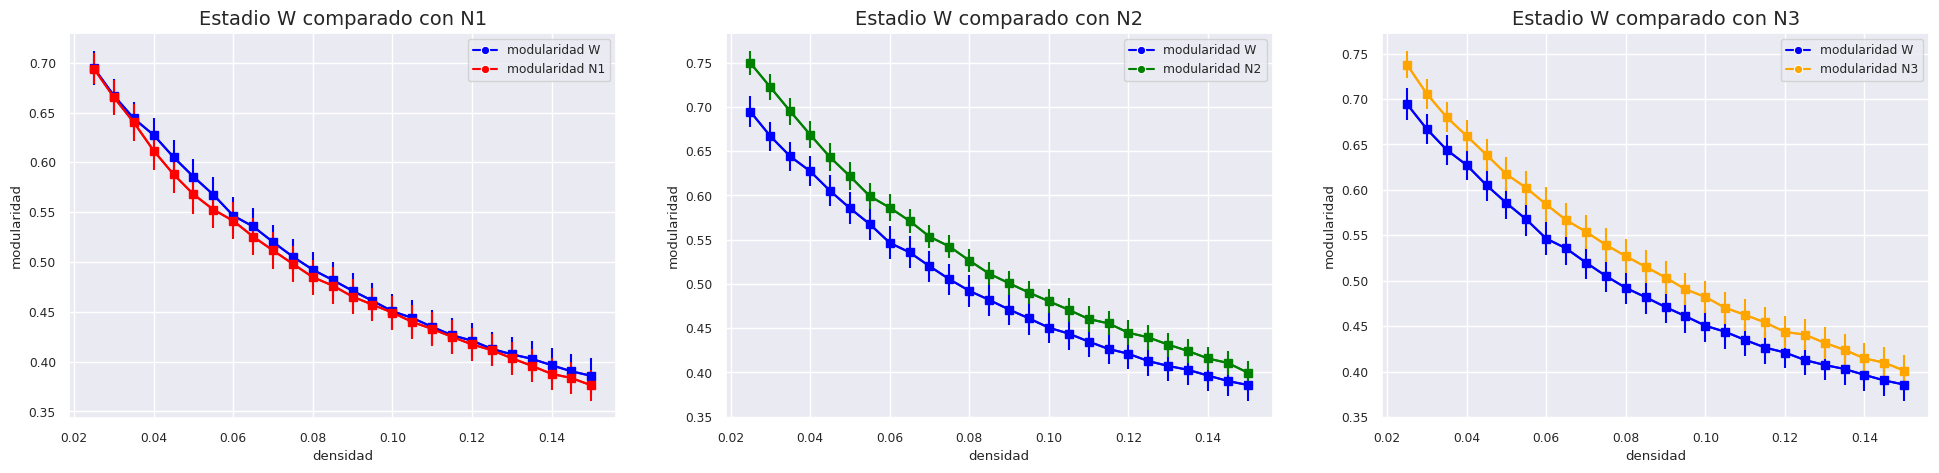

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(24, 5))
estadios = [['W', 'N1'], ['W','N2'], ['W','N3']]

for i, g in enumerate(estadios):
  df_m = graficar_metrica_estadio_vs_random(filenames_todos, g, g[0], colores, axs[i], 'modularidad', y_significatividad = 0.35, p_valor = p_valor_ajustado)

plt.show()

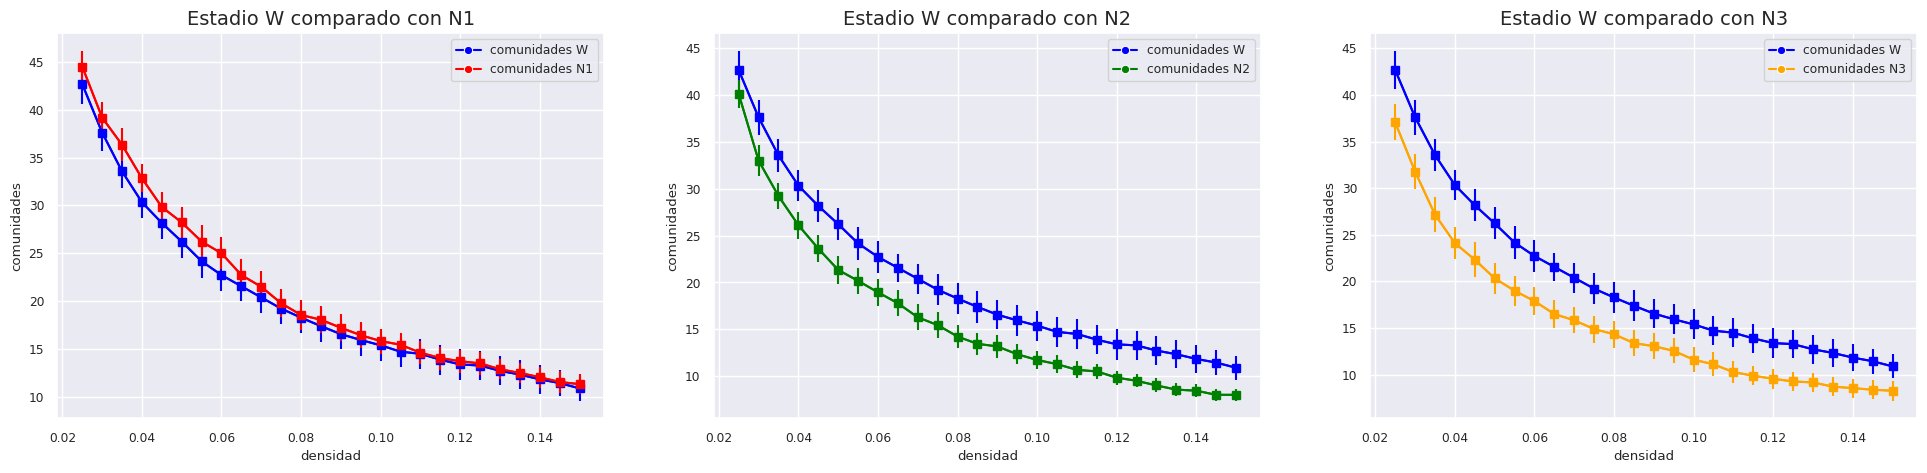

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(24, 5))
estadios = [['W', 'N1'], ['W','N2'], ['W','N3']]

for i, g in enumerate(estadios):
  df_m = graficar_metrica_estadio_vs_random(filenames_todos, g, g[0], colores, axs[i], 'comunidades', y_significatividad = 5, p_valor = p_valor_ajustado)

plt.show()




# Tarea 3: Diferencias en las comunidades para los diferentes estadíos


Para cada valor de densidad repetimos el siguiente análisis.

1) Para un estadío de sueño específico, y para cada sujeto dentro de ese estadío calculo las comunidades con Louvian. Calculo el AdjRandIndex para todos los pares de sujetos dentro del estadío de sueño. Promedio todos estos índices.

2) Repito el punto de arriba pero para el estadío despierto.

3) Promedio los valores promedio que obtuve para el estadío de sueño (punto 1) y los valores promedio del estadío despierto (punto 2). Con esto tengo el valor promedio entre el estadío de sueño y el estadío despierto (curvas azules de la Fig 5 del paper).

4) Ahora, para cada sujeto, permuto al azar con una probabilidad 0.5 el label despierto y el label de estadío de sueño.

5) Repito puntos 1, 2 y 3, para obtener la curva roja de la Fig 5 del paper.

## Tarea 3.1

In [ ]:
matrices_n1 = []
for i in range(0, len(filenames_n1)-1):
  ady_nx = calcular_matriz(filenames_n1[i])
  matrices_n1.append(ady_nx)

matrices_w = []
for i in range(0, len(filenames_w)-1):
  ady_wx = calcular_matriz(filenames_w[i])
  matrices_w.append(ady_wx)

matrices_n2 = []
for i in range(0, len(filenames_n2)-1):
  ady_nx2 = calcular_matriz(filenames_n2[i])
  matrices_n2.append(ady_nx2)

matrices_n3 = []
for i in range(0, len(filenames_n3)-1):
  ady_nx3 = calcular_matriz(filenames_n3[i])
  matrices_n3.append(ady_nx3)


In [ ]:
a = [1,1,1,1]
b = [4,4,4,4]
c = np.std(a+b)  / np.sqrt(len(a + b))
c

0.5303300858899106

In [ ]:
len(a+b)

8

In [ ]:
def calculate_ari_for_subject_pairs(matrices, resolution):
    all_ari_values = []

    # Calcula el índice de Rand ajustado para todos los pares de matrices (sujetos)
    subject_pairs = combinations(range(len(matrices)), 2)
    for pair in subject_pairs:
        matrix1, matrix2 = matrices[pair[0]], matrices[pair[1]]

        # Aplica el algoritmo de Louvain para detectar comunidades en cada matriz
        partition1 = community.best_partition(binarizar_matriz(matrix1, resolution))
        partition2 = community.best_partition(binarizar_matriz(matrix2, resolution))

        # Obtiene las etiquetas de comunidades de cada sujeto
        labels1 = list(partition1.values())
        labels2 = list(partition2.values())

        # Calcula el índice de Rand ajustado para los pares de sujetos
        ari = adjusted_rand_score(labels1, labels2)
        all_ari_values.append(ari)

    # Retorna una lista de índices de Rand ajustados para todos los pares de matrices (sujetos)
    return all_ari_values

# Supongamos que 'matrices_n1' es tu lista de matrices de adyacencia para el estado N1

# Calcula el índice de Rand ajustado para todos los pares de sujetos en el estado N1

#inicializo listas vacias
average_ari_n1 = []
average_ari_w = []
std_error_n1 = []
std_error_w = []
average_ari_n2 = []
average_ari_n3 = []
std_en3rror_n2 = []
std_error_ = []
randindex_obs_n1w_list = []
randindex_obs_n2w_list = []
randindex_obs_n3w_list= []
std_error_n1w_list = []
std_error_n2w_list = []
std_error_n3w_list = []

for d in densidades:

  all_ari_values_nx = calculate_ari_for_subject_pairs(matrices_n1, resolution = d)
  all_ari_values_nx2 = calculate_ari_for_subject_pairs(matrices_n2, resolution = d)
  all_ari_values_nx3 = calculate_ari_for_subject_pairs(matrices_n3, resolution = d)
  all_ari_values_wx = calculate_ari_for_subject_pairs(matrices_w, resolution = d)

  # Calcula el índice de Rand ajustado PROMEDIO para todos los pares de sujetos en el estado N1 para la densidad D dada
  mean_ari_n1 = np.mean(all_ari_values_nx)
  mean_ari_n2 = np.mean(all_ari_values_nx2)
  mean_ari_n3 = np.mean(all_ari_values_nx3)
  mean_ari_w = np.mean(all_ari_values_wx)

  average_ari_n1.append(mean_ari_n1)
  average_ari_n2.append(mean_ari_n2)
  average_ari_n3.append(mean_ari_n3)
  average_ari_w.append(mean_ari_w)

  randindex_obs_n1w = np.mean((mean_ari_n1, mean_ari_w))
  randindex_obs_n1w_list.append(randindex_obs_n1w)

  std_error_n1w = np.std(all_ari_values_nx) + np.std(all_ari_values_wx)
  std_error_n1w /= np.sqrt(len(all_ari_values_nx) + len(all_ari_values_wx))
  std_error_n1w_list.append(std_error_n1w)

  randindex_obs_n2w = np.mean((mean_ari_n2, mean_ari_w))
  randindex_obs_n2w_list.append(randindex_obs_n2w)

  std_error_n2w = np.std(all_ari_values_nx2) + np.std(all_ari_values_wx)
  std_error_n2w /= np.sqrt(len(all_ari_values_nx2) + len(all_ari_values_wx))
  std_error_n2w_list.append(std_error_n2w)

  randindex_obs_n3w = np.mean((mean_ari_n3, mean_ari_w))
  randindex_obs_n3w_list.append(randindex_obs_n3w)

  std_error_n3w = np.std(all_ari_values_nx3) + np.std(all_ari_values_wx)
  std_error_n3w /= np.sqrt(len(all_ari_values_nx3) + len(all_ari_values_wx))
  std_error_n3w_list.append(std_error_n3w)


  #all_ari_values_wx2 = calculate_ari_for_subject_pairs(matrices_w, resolution = d)

  # Calcula el índice de Rand ajustado promedio para todos los pares de sujetos en el estado N1


  #average_ari_w.append(np.mean(all_ari_values_wx))

#randindex_obs_n1w_final = np.mean((average_ari_n1, average_ari_w))
#randindex_obs_n2w_final = np.mean((average_ari_n2, average_ari_w))
#randindex_obs_n3w_final = np.mean((average_ari_n3, average_ari_w))
print(f'El promedio índice de Rand ajustado promedio observado  para N1 x W es : {randindex_obs_n1w_list}')
print(f'El promedio índice de Rand ajustado promedio observado  para N2 x W es : {randindex_obs_n2w_list}')
print(f'El promedio índice de Rand ajustado promedio observado  para N3 x W es : {randindex_obs_n3w_list}')




El promedio índice de Rand ajustado promedio observado  para N1 x W es : [0.35046494435512876, 0.34714116187545746, 0.34150744977696534, 0.335792646101875, 0.32595324987998864, 0.31583314859342976, 0.2996809437036427, 0.3034900801317057, 0.2998322784415368, 0.29342748643510735, 0.28944271612594236, 0.2813585616064192, 0.2883538964726004, 0.28221258278059336, 0.2755150373950062, 0.26712366986951186, 0.2774351367202905, 0.27806624711997036, 0.2728555156718241, 0.28039036352785823, 0.2771543059163564, 0.2734745181360982, 0.2687848078734836, 0.27140267013673736, 0.2695279056198828, 0.27079755600335575]
El promedio índice de Rand ajustado promedio observado  para N2 x W es : [0.3943162244252452, 0.37743868239922884, 0.3723086492818717, 0.3659452616247211, 0.36172542474617886, 0.3569482914242943, 0.34293932056594845, 0.33919757463323713, 0.33037325742676094, 0.31958850115125204, 0.3162375852239695, 0.3105035585722687, 0.30674241979803274, 0.30454518213439574, 0.3004391812742505, 0.2962577372

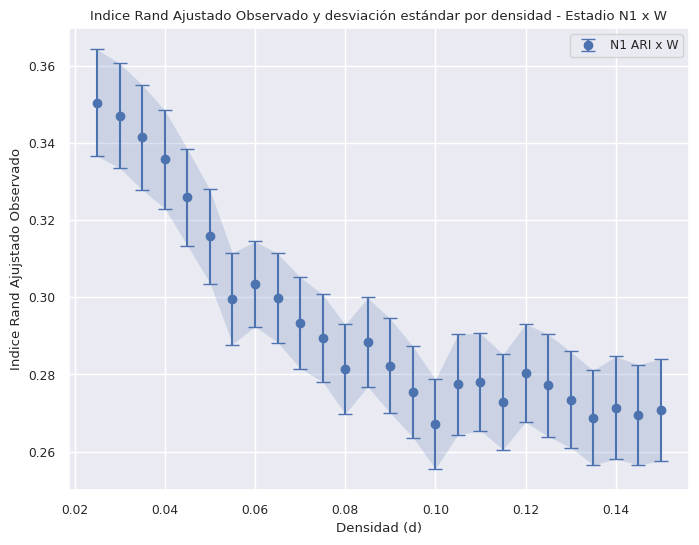

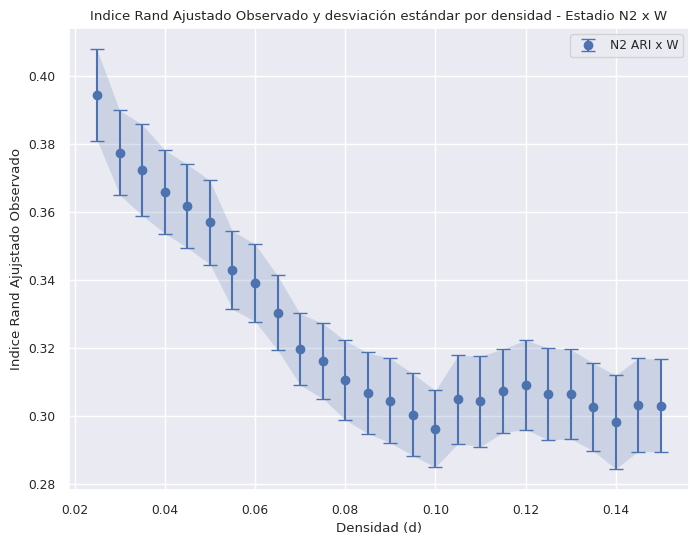

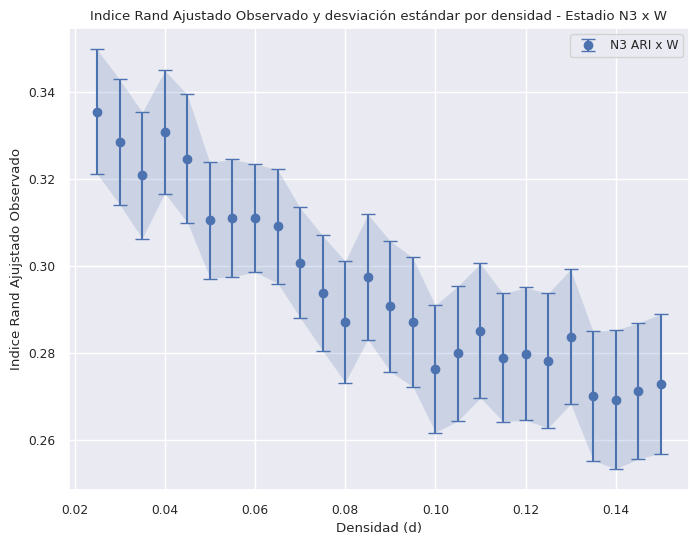

In [ ]:
# Grafica los resultados n1
plt.errorbar(densidades, randindex_obs_n1w_list, yerr=std_error_n1w_list, fmt='o', capsize=5, label='N1 ARI x W')
plt.fill_between(densidades, np.array(randindex_obs_n1w_list) - np.array(std_error_n1w_list),
                 np.array(randindex_obs_n1w_list) + np.array(std_error_n1w_list), alpha=0.2)
plt.xlabel('Densidad (d)')
plt.ylabel('Indice Rand Ajujstado Observado')
plt.title('Indice Rand Ajustado Observado y desviación estándar por densidad - Estadio N1 x W')
plt.legend()
plt.show()


# Grafica los resultados n2
plt.errorbar(densidades, randindex_obs_n2w_list, yerr=std_error_n2w_list, fmt='o', capsize=5, label='N2 ARI x W')
plt.fill_between(densidades, np.array(randindex_obs_n2w_list) - np.array(std_error_n2w_list),
                 np.array(randindex_obs_n2w_list) + np.array(std_error_n2w_list), alpha=0.2)
plt.xlabel('Densidad (d)')
plt.ylabel('Indice Rand Ajujstado Observado')
plt.title('Indice Rand Ajustado Observado y desviación estándar por densidad - Estadio N2 x W')
plt.legend()
plt.show()


## Grafica los resultados n3
plt.errorbar(densidades, randindex_obs_n3w_list, yerr=std_error_n3w_list, fmt='o', capsize=5, label='N3 ARI x W' )
plt.fill_between(densidades, np.array(randindex_obs_n3w_list) - np.array(std_error_n3w_list),
                 np.array(randindex_obs_n3w_list) + np.array(std_error_n3w_list), alpha=0.2)
plt.xlabel('Densidad (d)')
plt.ylabel('Indice Rand Ajujstado Observado')
plt.title('Indice Rand Ajustado Observado y desviación estándar por densidad - Estadio N3 x W')
plt.legend()
plt.show()




In [ ]:
df_observados_n1w = pd.DataFrame({
    "rand_index_observado": randindex_obs_n1w_list,
    "sem": std_error_n1w_list,
    "densidades": densidades
})
df_observados_n1w.to_csv('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/df_observados_n1w.csv')

df_observados_n2w = pd.DataFrame({
    "rand_index_observado": randindex_obs_n2w_list,
    "sem": std_error_n2w_list,
    "densidades": densidades
})
df_observados_n2w.to_csv('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/df_observados_n2w.csv')

df_observados_n3w = pd.DataFrame({
    "rand_index_observado": randindex_obs_n3w_list,
    "sem": std_error_n3w_list,
    "densidades": densidades
})

df_observados_n3w.to_csv('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/df_observados_n3w.csv')

### Levanta rand index observados

In [ ]:
df_observados_n1w = pd.read_csv(working_path + 'df_observados_n1w.csv')
df_observados_n2w = pd.read_csv(working_path + 'df_observados_n2w.csv')
df_observados_n3w = pd.read_csv(working_path + 'df_observados_n3w.csv')

In [ ]:
df_observados_n1w

Unnamed: 0  rand_index_observado       sem  densidades
0            0              0.350465  0.013912       0.025
1            1              0.347141  0.013682       0.030
2            2              0.341507  0.013704       0.035
3            3              0.335793  0.012843       0.040
4            4              0.325953  0.012664       0.045
5            5              0.315833  0.012261       0.050
6            6              0.299681  0.011958       0.055
7            7              0.303490  0.011098       0.060
8            8              0.299832  0.011605       0.065
9            9              0.293427  0.011954       0.070
10          10              0.289443  0.011418       0.075
11          11              0.281359  0.011684       0.080
12          12              0.288354  0.011642       0.085
13          13              0.282213  0.012319       0.090
14          14              0.275515  0.011925       0.095
15          15              0.267124  0.011723       0.100
16          16              0.277435  0.013142       0.105
17          17              0.278066  0.012713       0.110
18          18              0.272856  0.012443       0.115
19          19              0.280390  0.012814       0.120
20          20              0.277154  0.013359       0.125
21          21              0.273475  0.012505       0.130
22          22              0.268785  0.012376       0.135
23          23              0.271403  0.013384       0.140
24          24              0.269528  0.013047       0.145
25          25              0.270798  0.013318       0.150

## Tarea 3.4

In [ ]:
import itertools
import copy

matrices_b_n1 = copy.deepcopy(matrices_n1)
matrices_b_n2 = copy.deepcopy(matrices_n2)
matrices_b_n3 = copy.deepcopy(matrices_n3)
matrices_b_w = copy.deepcopy(matrices_w)

# Función para realizar permutaciones intra grupo
def matrix_permutations(matrix_1, matrix_2,p):
  permuted_group1 = []
  permuted_group2 = []
  for i in range(0, len(matrix_1)-1):
          # Decide con una probabilidad del 50% si se intercambian
          if np.random.rand() > p:
              permuted_group1.append(matrix_2[i])
              permuted_group2.append(matrix_1[i])
          else:
              permuted_group1.append(matrix_1[i])
              permuted_group2.append(matrix_2[i])
  return permuted_group1, permuted_group2


In [ ]:

def calcular_randind_permutado(densidades, permutaciones, matrices1, matrices2, prob, randsobservados):
  randindex_promedios_permutados =[]
  std_error_permutados = []
  p_values_permutados = []

  for i in range(0, len(densidades)):
    randindex_permutaciones = []
    avg_randindex_permutado_grupo2 = []
    std_error_grupo1 = []
    std_error_grupo2 = []

    for k in range(0, permutaciones):
      #hago las permutaciones
      permuted_group1, permuted_group2 = matrix_permutations(matrices1, matrices2, prob)
      #para cada grupo ahora permutado, calculo los rand index por pares
      adj_rand_values_g1 = calculate_ari_for_subject_pairs(permuted_group1, resolution = densidades[i])
      adj_rand_values_g2 = calculate_ari_for_subject_pairs(permuted_group2, resolution = densidades[i])


      #Junto los rand index promedio de cada grupo para esta permutacion
      mean_g1 = np.mean(adj_rand_values_g1)
      mean_g2 = np.mean(adj_rand_values_g2)

      #Calculo el rand index permutado
      mean_g1g2 = np.mean((mean_g1, mean_g2))

      #Guardo el rand index permutado
      randindex_permutaciones.append(mean_g1g2)


    #Calculo el promedio de mis rand index permutados

    randindex_promedios_permutados.append(np.mean(randindex_permutaciones))

    #Calculo el sem de mis rand index permutados (de todas las permutaciones)
    std_error_permutaciones = np.std(randindex_permutaciones) / np.sqrt(len(randindex_permutaciones))
    std_error_permutados.append(std_error_permutaciones)

    #Junto los p-values comparando mi promedio permutado con mi rand_observado
    p_value_permutado = randindex_promedios_permutados.count(lambda elemento: elemento > randsobservados[i]) / permutaciones
    p_values_permutados.append(p_value_permutado)

  return p_values_permutados, randindex_promedios_permutados , std_error_permutados


In [ ]:

#p_valores_n1w, randperm_n1w , sem_perm_n1w = calcular_randind_permutado(densidades, 100, matrices_n1, matrices_w, 0.5, randindex_obs_n1w_list)

In [ ]:
#df_permutados_n1w = pd.DataFrame({
#    "p-value": p_valores_n1w,
#    "rand_index_permutado": randperm_n1w,
#    "std_error": sem_perm_n1w,
#    "densidad" : densidades
#})

#df_permutados_n1w.to_csv('/content/drive/MyDrive/Maestria/DMCyT/pre-TP2/df_permutados_n1w.csv')

In [ ]:
#df_permutaciones.to_csv('/df_permutaciones_values_n1w.csv')

### Levanta rand permutados

In [ ]:
df_permutados_n1w = pd.read_csv(working_path + 'df_permutados_n1w.csv')
df_permutados_n2w = pd.read_csv(working_path + 'df_permutados_n2w.csv')
df_permutados_n3w = pd.read_csv(working_path + 'df_permutados_n3w.csv')


In [ ]:
permutaciones_n1w = pd.read_csv(working_path + 'permutaciones_totales_n1w.csv')
permutaciones_n2w = pd.read_csv(working_path + 'permutaciones_totales_n2w.csv')
permutaciones_n3w = pd.read_csv(working_path + 'permutaciones_totales_n3w.csv')


In [ ]:
import ast
permutaciones_n1w['lista_permutaciones'] = permutaciones_n1w['lista_permutaciones'].apply(ast.literal_eval)
permutaciones_n2w['lista_permutaciones'] = permutaciones_n2w['lista_permutaciones'].apply(ast.literal_eval)
permutaciones_n3w['lista_permutaciones'] = permutaciones_n3w['lista_permutaciones'].apply(ast.literal_eval)

In [ ]:
lista_permutaciones_n1w = permutaciones_n1w['lista_permutaciones']
lista_permutaciones_n2w = permutaciones_n2w['lista_permutaciones']
lista_permutaciones_n3w = permutaciones_n3w['lista_permutaciones']

In [ ]:
df_permutados_n1w

Unnamed: 0  p-value  rand_index_permutado  std_error  densidad
0            0     0.09              0.346954   0.000265     0.025
1            1     0.18              0.344653   0.000278     0.030
2            2     0.76              0.343513   0.000293     0.035
3            3     0.42              0.335074   0.000291     0.040
4            4     0.22              0.323200   0.000321     0.045
5            5     0.81              0.318565   0.000292     0.050
6            6     0.81              0.302261   0.000294     0.055
7            7     0.81              0.305952   0.000267     0.060
8            8     0.70              0.301545   0.000283     0.065
9            9     0.92              0.297427   0.000281     0.070
10          10     0.69              0.291195   0.000365     0.075
11          11     0.86              0.284778   0.000300     0.080
12          12     0.16              0.285226   0.000314     0.085
13          13     0.53              0.282305   0.000307     0.090
14          14     0.39              0.275061   0.000355     0.095
15          15     0.99              0.273056   0.000325     0.100
16          16     0.32              0.276056   0.000314     0.105
17          17     0.31              0.276303   0.000375     0.110
18          18     0.67              0.274849   0.000387     0.115
19          19     0.01              0.272729   0.000318     0.120
20          20     0.17              0.274087   0.000338     0.125
21          21     0.07              0.267983   0.000341     0.130
22          22     0.06              0.264258   0.000330     0.135
23          23     0.00              0.263526   0.000287     0.140
24          24     0.04              0.264519   0.000301     0.145
25          25     0.03              0.263862   0.000343     0.150

In [ ]:
#P-value n1w
lista_rand_obs_n1w = df_observados_n1w['rand_index_observado']
p_values_n1w = []
for i in range(0, len(lista_permutaciones_n1w)):
  p_val = 0
  for elemento in lista_permutaciones_n1w[i]:
    if elemento > lista_rand_obs_n1w[i]:
      p_val = p_val + 1
  p_val = p_val / 100
  p_values_n1w.append(p_val)

p_values_n1w

df_permutados_n1w['p-value'] = p_values_n1w

In [ ]:
#P-value n2w
lista_rand_obs_n2w = df_observados_n2w['rand_index_observado']
p_values_n2w = []
for i in range(0, len(lista_permutaciones_n2w)):
  p_val = 0
  for elemento in lista_permutaciones_n2w[i]:
    if elemento > lista_rand_obs_n2w[i]:
      p_val = p_val + 1
  p_val = p_val / 100
  p_values_n2w.append(p_val)

p_values_n2w

df_permutados_n2w['p-value'] = p_values_n2w

In [ ]:
#P-value n2w
lista_rand_obs_n3w = df_observados_n3w['rand_index_observado']
p_values_n3w = []
for i in range(0, len(lista_permutaciones_n3w)):
  p_val = 0
  for elemento in lista_permutaciones_n3w[i]:
    if elemento > lista_rand_obs_n3w[i]:
      p_val = p_val + 1
  p_val = p_val / 100
  p_values_n3w.append(p_val)


df_permutados_n3w['p-value'] = p_values_n3w

In [ ]:
df_n1w = pd.merge(df_permutados_n1w, df_observados_n1w, left_on='densidad', right_on = 'densidades')
df_n2w = pd.merge(df_permutados_n2w, df_observados_n2w, left_on='densidad', right_on = 'densidades')
df_n3w = pd.merge(df_permutados_n3w, df_observados_n3w, left_on='densidad', right_on = 'densidades')




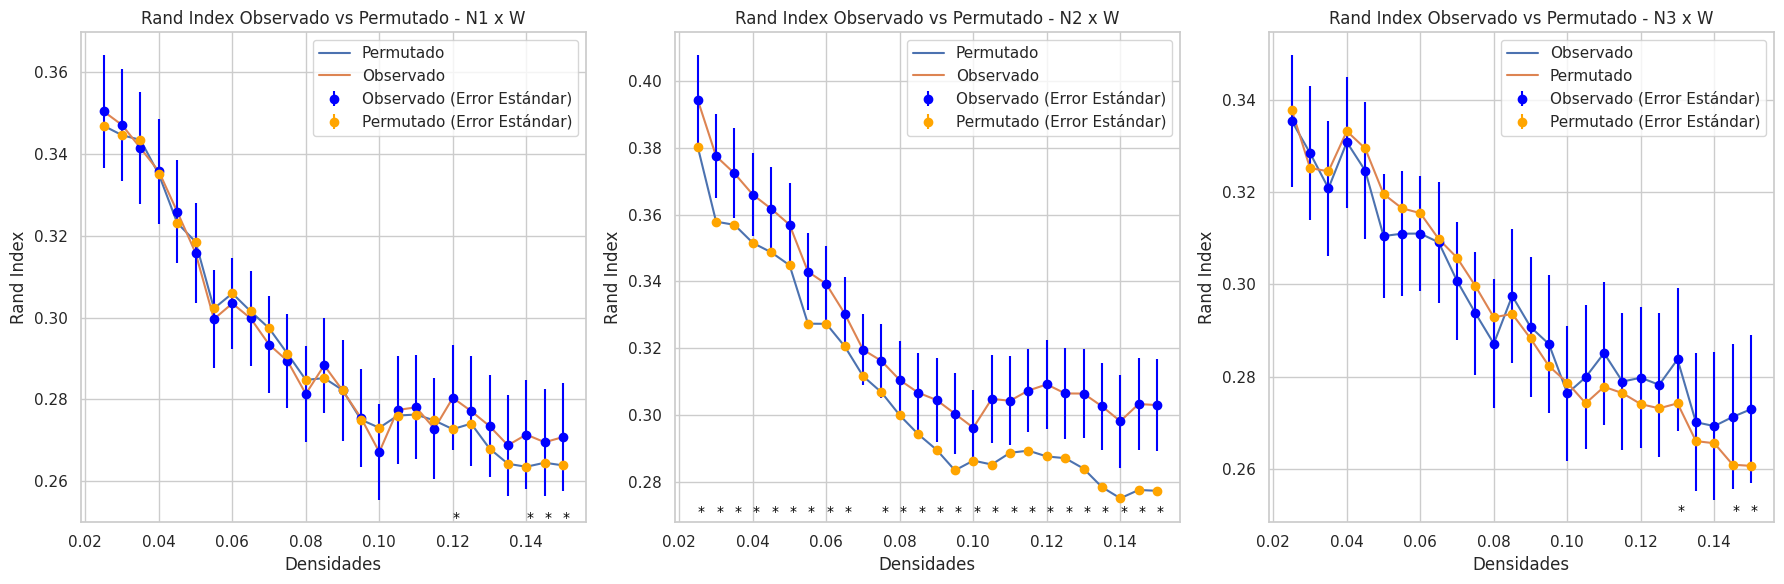

In [ ]:
# Configura el estilo de seaborn (opcional)
# Configura el estilo de seaborn (opcional)
sns.set(style="whitegrid")

# Crea el lienzo rectangular con tres subgráficos uno al lado del otro
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Gráfico 1: Rand Index Observado - df_n1w
sns.lineplot(data=df_n1w, x='densidades', y='rand_index_permutado', label='Permutado', ax=axes[0])
sns.lineplot(data=df_n1w, x='densidades', y='rand_index_observado', label='Observado', ax=axes[0])
axes[0].errorbar(df_n1w['densidades'], df_n1w['rand_index_observado'], yerr=df_n1w['sem'], fmt='o', color='blue', label='Observado (Error Estándar)')
axes[0].errorbar(df_n1w['densidades'], df_n1w['rand_index_permutado'], yerr=df_n1w['std_error'], fmt='o', color='orange', label='Permutado (Error Estándar)')
axes[0].set_xlabel('Densidades')
axes[0].set_ylabel('Rand Index')
axes[0].set_title('Rand Index Observado vs Permutado - N1 x W')
for index, row in df_n1w.iterrows():
    if row['p-value'] < 0.05:
        axes[0].text(row['densidades'], 0.25, '*', color='black', fontsize=10)
axes[0].legend()

# Gráfico 2: Rand Index Permutado - df_n2w
sns.lineplot(data=df_n2w, x='densidades', y='rand_index_permutado', label='Permutado', ax=axes[1])
sns.lineplot(data=df_n2w, x='densidades', y='rand_index_observado', label='Observado', ax=axes[1])
axes[1].errorbar(df_n2w['densidades'], df_n2w['rand_index_observado'], yerr=df_n2w['sem'], fmt='o', color='blue', label='Observado (Error Estándar)')
axes[1].errorbar(df_n2w['densidades'], df_n2w['rand_index_permutado'], yerr=df_n2w['std_error'], fmt='o', color='orange', label='Permutado (Error Estándar)')
axes[1].set_xlabel('Densidades')
axes[1].set_ylabel('Rand Index')
axes[1].set_title('Rand Index Observado vs Permutado - N2 x W')
for index, row in df_n2w.iterrows():
    if row['p-value'] < 0.05:
        axes[1].text(row['densidades'], 0.27, '*', color='black', fontsize=10)
axes[1].legend()
# Gráfico 3: Puntos Marcados con "*" - df_n3w
sns.lineplot(data=df_n3w, x='densidades', y='rand_index_observado',  label='Observado', ax=axes[2])
sns.lineplot(data=df_n3w, x='densidades', y='rand_index_permutado', label='Permutado', ax=axes[2])
axes[2].errorbar(df_n3w['densidades'], df_n3w['rand_index_observado'], yerr=df_n3w['sem'], fmt='o', color='blue', label='Observado (Error Estándar)')
axes[2].errorbar(df_n3w['densidades'], df_n3w['rand_index_permutado'], yerr=df_n3w['std_error'], fmt='o', color='orange', label='Permutado (Error Estándar)')
# Marca "*" si p-value es < 0.05
for index, row in df_n3w.iterrows():
    if row['p-value'] < 0.05:
        axes[2].text(row['densidades'], 0.25, '*', color='black', fontsize=10)
axes[2].set_xlabel('Densidades')
axes[2].set_ylabel('Rand Index')
axes[2].set_title('Rand Index Observado vs Permutado - N3 x W')
axes[2].legend()

# Ajusta el diseño y muestra el lienzo rectangular
plt.tight_layout()
plt.show()


# Opcional 3: Rol de nodos, y cambios en el rol de los nodos

## Item 1

In [ ]:
densidad_interesante_w = 0.065
densidad_interesante_n1 = 0.065
densidad_interesante_n2 = 0.065
densidad_interesante_n3 = 0.065

In [ ]:
#Louvain
G = binarizar_matriz (ady_w, densidad_interesante_w)
G = binarizar_matriz (ady_w, 0.075)

partition = community.best_partition(G, random_state=42)
#modularidad = community.modularity(partition, G)


In [ ]:
communities = community.best_partition(G, random_state=42)
print (communities)

zis = calculate_zi_scores(G)

comunidades_dict = {}

# Llenar el diccionario con nodos correspondientes a cada comunidad
for nodo, comunidad in communities.items():
    if comunidad in comunidades_dict:
        comunidades_dict[comunidad].append(nodo)
    else:
        comunidades_dict[comunidad] = [nodo]

{0: 0, 1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 1, 19: 0, 20: 2, 21: 2, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 0, 29: 0, 30: 1, 31: 1, 32: 1, 33: 1, 34: 4, 35: 4, 36: 5, 37: 5, 38: 5, 39: 5, 40: 5, 41: 5, 42: 4, 43: 4, 44: 4, 45: 4, 46: 4, 47: 4, 48: 4, 49: 4, 50: 4, 51: 4, 52: 4, 53: 4, 54: 4, 55: 4, 56: 0, 57: 4, 58: 4, 59: 4, 60: 4, 61: 4, 62: 0, 63: 0, 64: 4, 65: 4, 66: 4, 67: 4, 68: 0, 69: 0, 70: 8, 71: 8, 72: 8, 73: 8, 74: 8, 75: 8, 76: 8, 77: 8, 78: 0, 79: 0, 80: 0, 81: 0, 82: 0, 83: 0, 84: 4, 85: 4, 86: 0, 87: 0, 88: 4, 89: 4, 90: 3, 91: 3, 92: 3, 93: 3, 94: 3, 95: 3, 96: 3, 97: 3, 98: 3, 99: 3, 100: 3, 101: 3, 102: 3, 103: 3, 104: 3, 105: 3, 106: 6, 107: 7, 108: 9, 109: 3, 110: 3, 111: 3, 112: 3, 113: 3, 114: 3, 115: 10}


In [ ]:
comunidades_dict[0]

[0,
 1,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 19,
 28,
 29,
 56,
 62,
 63,
 68,
 69,
 78,
 79,
 80,
 81,
 82,
 83,
 86,
 87]

In [ ]:

nuevo_coeficientes_dict = {nodo: coeficiente for nodo, coeficiente in zis.items() if nodo in comunidades_dict[0]}
nuevo_coeficientes_dict


{0: 0.3029733134869456,
 1: 0.13886276868151678,
 10: -0.6816899553456273,
 11: -0.35346886573476965,
 12: -0.8458005001510561,
 13: -0.8458005001510561,
 14: -1.5022426793727715,
 15: -1.009911044956485,
 16: 0.4670838582923744,
 17: 0.3029733134869456,
 19: 0.13886276868151678,
 28: 0.4670838582923744,
 29: 0.3029733134869456,
 56: -0.025247776123912036,
 62: -0.18935832092934085,
 63: -0.5175794105401985,
 68: -1.1740215897619137,
 69: -1.1740215897619137,
 78: -0.6816899553456273,
 79: -0.35346886573476965,
 80: 0.4670838582923744,
 81: 0.4670838582923744,
 82: -0.8458005001510561,
 83: -0.35346886573476965,
 86: -1.6663532241782002,
 87: -1.6663532241782002}

In [ ]:
G = binarizar_matriz (ady_w, 0.075)

partition = community.best_partition(G, random_state=42)
communities = community.best_partition(G, random_state=42)

In [ ]:
print (communities)
print (partition)

{0: 0, 1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 1, 19: 0, 20: 2, 21: 2, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 0, 29: 0, 30: 1, 31: 1, 32: 1, 33: 1, 34: 4, 35: 4, 36: 5, 37: 5, 38: 5, 39: 5, 40: 5, 41: 5, 42: 4, 43: 4, 44: 4, 45: 4, 46: 4, 47: 4, 48: 4, 49: 4, 50: 4, 51: 4, 52: 4, 53: 4, 54: 4, 55: 4, 56: 0, 57: 4, 58: 4, 59: 4, 60: 4, 61: 4, 62: 0, 63: 0, 64: 4, 65: 4, 66: 4, 67: 4, 68: 0, 69: 0, 70: 8, 71: 8, 72: 8, 73: 8, 74: 8, 75: 8, 76: 8, 77: 8, 78: 0, 79: 0, 80: 0, 81: 0, 82: 0, 83: 0, 84: 4, 85: 4, 86: 0, 87: 0, 88: 4, 89: 4, 90: 3, 91: 3, 92: 3, 93: 3, 94: 3, 95: 3, 96: 3, 97: 3, 98: 3, 99: 3, 100: 3, 101: 3, 102: 3, 103: 3, 104: 3, 105: 3, 106: 6, 107: 7, 108: 9, 109: 3, 110: 3, 111: 3, 112: 3, 113: 3, 114: 3, 115: 10}
{0: 0, 1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 1, 19: 0, 20: 2, 21: 2, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 

In [ ]:
neighbors = [n for n in G.neighbors(0) if communities[n] == communities[0]]
kin = len(neighbors)

In [ ]:
print (neighbors)
print (kin)

[1, 10, 11, 12, 13, 16, 17, 19, 56, 62, 68, 69, 80, 81]
14


In [ ]:
# Media y desvio comunidad
degrees = [len(list(G.neighbors(n))) for n in G if communities[n] == communities[0]]
mu_in = np.mean(degrees)
sigma_in = np.std(degrees)
print (mu_in)
print (sigma_in)

12.153846153846153
6.093453660674946


In [ ]:
#TODO: Revisar el calculo del zi_score
if sigma_in != 0:
  zi = (kin - mu_in) / sigma_in
else:
  zi = 3.537764214218853
  zi = 0
print (zi)

0.3029733134869456


In [ ]:
# Detectamos comunidades
communities = community.best_partition(G, random_state=42)
zi = calc_zi(G, communities, 0)
zi


0.3029733134869456

In [ ]:

def calc_zi(G, communities, node):
    neighbors = [n for n in G.neighbors(node) if communities[n] == communities[node]]
    kin = len(neighbors)

    # Media y desvio comunidad
    degrees = [len(list(G.neighbors(n))) for n in G if communities[n] == communities[node]]
    mu_in = np.mean(degrees)
    sigma_in = np.std(degrees)

    #TODO: Revisar el calculo del zi_score
    if sigma_in != 0:
      zi = (kin - mu_in) / sigma_in
    else:
      zi = 3.537764214218853
      zi = 0

    return zi

def calculate_zi_scores (G):
  # Detectamos comunidades
  communities = community.best_partition(G, random_state=42)

  zi_values = {}

  for n in G.nodes():
      zi = calc_zi(G, communities, n)
      zi_values[n] = zi # Guardamos los zi

  return zi_values


In [ ]:

def calculate_participation_coeficients(G):
  # Detectar comunidades
  communities = nx.community.louvain_communities(G, seed = 42)

  # Diccionario de coeficientes de participación por nodo
  participation_coefficients = {}

  # Iterar sobre comunidades
  for c, community in enumerate(communities):

    # Subgrafo inducido por la comunidad
    G_subgraph = G.subgraph(community)

    # Iterar sobre nodos de la comunidad
    for n in community:

      # Enlaces internos del nodo
      internal_links = G_subgraph.degree(n)

      # Grado total del nodo
      total_degree = G.degree(n)

      if total_degree == 0:
        participation_coefficients[n] = 1
        continue
      # Calcular coeficiente de participación
      p = 1 - ((internal_links / float(total_degree)) ** 2)

      # Guardar en diccionario
      participation_coefficients[n] = p

  return participation_coefficients



In [ ]:
def generar_labels(G, densidad, zi_zcores,  p_i_coeficients, labels_info, estadio, sujeto):

  p_zi = 1
  p_c = 0.05
  for n in G.nodes():

    if p_i_coeficients[n] > p_c:
      if zi_zcores[n] > p_zi:
        label = 'hub'
      else:
        label = 'connector_node'
    else:
      if zi_zcores[n] > p_zi:
        label = 'provincial_hub'
      else:
        label = 'provincial_node'

    labels_info.append((densidad, n, zi_zcores[n], p_i_coeficients[n], partition[n], label, estadio, sujeto))

  return labels_info


Graficar el número de nodos por cada clase en función de δ, y comparar estadísticamente cada estadio N1, N2 y N3, con el estadio despierto W.

In [ ]:

def extraer_data(filename):
  estadio = re.search(r"([^/]+)_", filename).group(1)
  sujeto = re.search(r"suj(\d+)\.", filename).group(1)

  return estadio, sujeto


In [ ]:
labels_info = []

for d in densidades: # Recorro todas las densidades
  for e in filenames_todos: #Recorro los 4 estadios
    for f in filenames_todos[e]: #recorro todos los archivos de cada estadio

      m = calcular_matriz(f)
      G = binarizar_matriz(m, d)

      estadio, sujeto = extraer_data(str(f))

      zi_zcores = calculate_zi_scores(G)
      p_i_coeficients =  calculate_participation_coeficients(G)

      labels_info = generar_labels(G, d, zi_zcores, p_i_coeficients, labels_info, estadio, sujeto)


df_labels = pd.DataFrame(labels_info, columns=['densidad', 'nodo', 'zi', 'pi', 'comunidad', 'label', 'estadio', 'sujeto'])

df_labels

densidad  nodo        zi        pi  comunidad            label  \
0          0.025     0 -1.341960  0.000000          0  provincial_node   
1          0.025     1  0.688247  0.000000          0  provincial_node   
2          0.025     2  0.404304  0.640000          1   connector_node   
3          0.025     3 -0.642081  0.510000          1   connector_node   
4          0.025     4 -1.341960  0.000000          1  provincial_node   
...          ...   ...       ...       ...        ...              ...   
217147     0.150   111 -0.708700  0.555556          3   connector_node   
217148     0.150   112 -1.413727  0.360000          3   connector_node   
217149     0.150   113  0.000000  1.000000          3   connector_node   
217150     0.150   114  0.000000  1.000000          3   connector_node   
217151     0.150   115  0.000000  1.000000         10   connector_node   

       estadio sujeto  
0            W      1  
1            W      1  
2            W      1  
3            W      1  
4            W      1  
...        ...    ...  
217147      N3      9  
217148      N3      9  
217149      N3      9  
217150      N3      9  
217151      N3      9  

[217152 rows x 8 columns]

In [ ]:
df_labels.loc[(df_labels['estadio'] == 'W') & (df_labels['sujeto'] == '10') & (df_labels['nodo'] == '0') ]
df_labels.loc[(df_labels['estadio'] == 'W') & (df_labels['sujeto'] == '10') & (df_labels['nodo'] == 21)]
df_labels.loc[(df_labels['label'] == 'provincial_node')]
df_labels.loc[(df_labels['label'] == 'provincial_hub')]




densidad  nodo        zi   pi  comunidad           label estadio  \
17         0.025    17  1.605910  0.0          0  provincial_hub       W   
42         0.025    42  1.414214  0.0          4  provincial_hub       W   
47         0.025    47  1.037749  0.0          4  provincial_hub       W   
82         0.025    82  1.414214  0.0          0  provincial_hub       W   
85         0.025    85  1.037749  0.0          4  provincial_hub       W   
...          ...   ...       ...  ...        ...             ...     ...   
216786     0.150    98  1.178969  0.0          3  provincial_hub      N3   
216791     0.150   103  1.052972  0.0          3  provincial_hub      N3   
216792     0.150   104  1.178969  0.0          3  provincial_hub      N3   
216793     0.150   105  1.304965  0.0          3  provincial_hub      N3   
216802     0.150   114  1.304965  0.0          3  provincial_hub      N3   

       sujeto  
17          1  
42          1  
47          1  
82          1  
85          1  
...       ...  
216786      6  
216791      6  
216792      6  
216793      6  
216802      6  

[5359 rows x 8 columns]

(array([1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 4.0000e+00,
        5.0000e+00, 4.0000e+00, 4.0000e+00, 5.0000e+00, 8.0000e+00,
        5.0000e+01, 1.4500e+02, 4.1500e+02, 1.5850e+03, 5.6440e+03,
        1.3582e+04, 2.5068e+04, 3.4137e+04, 3.3874e+04, 5.6302e+04,
        1.9452e+04, 1.2554e+04, 7.9650e+03, 3.9660e+03, 1.5600e+03,
        5.8200e+02, 1.8200e+02, 3.8000e+01, 1.2000e+01, 7.0000e+00]),
 array([-7.        , -6.64874119, -6.29748239, -5.94622358, -5.59496477,
        -5.24370596, -4.89244716, -4.54118835, -4.18992954, -3.83867074,
        -3.48741193, -3.13615312, -2.78489431, -2.43363551, -2.0823767 ,
        -1.73111789, -1.37985909, -1.02860028, -0.67734147, -0.32608266,
         0.02517614,  0.37643495,  0.72769376,  1.07895256,  1.43021137,
         1.78147018,  2.13272899,  2.48398779,  2.8352466 ,  3.18650541,
         3.53776421]),
 <BarContainer object of 30 artists>)

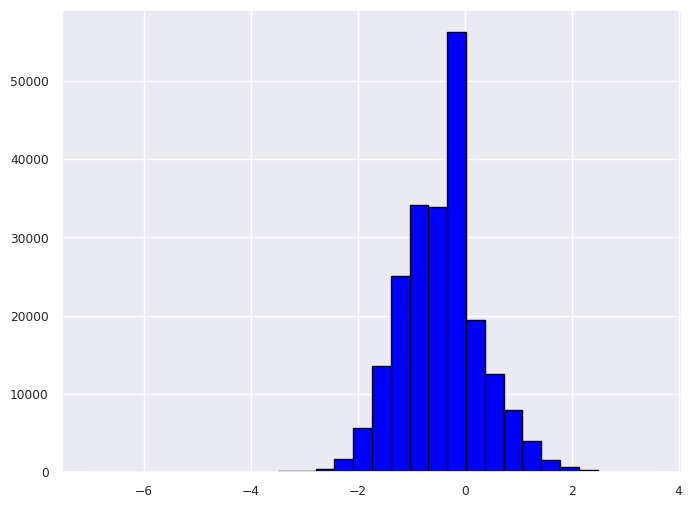

In [ ]:
plt.hist(df_labels['zi'], bins=30, color='blue', edgecolor='black')


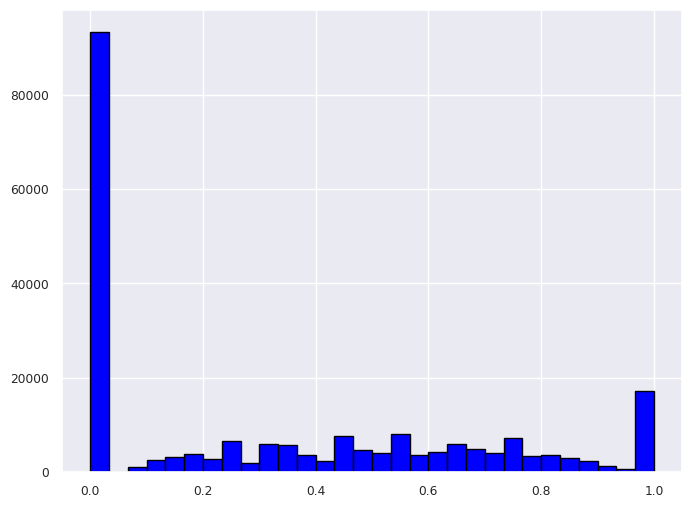

In [ ]:
plt.hist(df_labels['pi'], bins=30, color='blue', edgecolor='black')
df_labels.to_csv('archivo_zi_score0.csv', index=False)


In [ ]:
df_plot_040 = df_labels.loc[(df_labels['densidad']>= 0.04) & (df_labels['densidad']<= 0.041)]
df_plot_040
#df_labels.dtypes


densidad  nodo        zi        pi  comunidad            label estadio  \
25056      0.04     0 -0.507536  0.000000          0  provincial_node       W   
25057      0.04     1  1.290994  0.000000          0   provincial_hub       W   
25058      0.04     2  0.334525  0.209877          1   connector_node       W   
25059      0.04     3  0.575383  0.719723          1   connector_node       W   
25060      0.04     4 -0.908843  0.000000          1  provincial_node       W   
...         ...   ...       ...       ...        ...              ...     ...   
33403      0.04   111  0.000000  1.000000          3   connector_node      N3   
33404      0.04   112  0.000000  1.000000          3   connector_node      N3   
33405      0.04   113  0.000000  1.000000          3   connector_node      N3   
33406      0.04   114  0.000000  1.000000          3   connector_node      N3   
33407      0.04   115  0.000000  1.000000         10   connector_node      N3   

      sujeto  
25056      1  
25057      1  
25058      1  
25059      1  
25060      1  
...      ...  
33403      9  
33404      9  
33405      9  
33406      9  
33407      9  

[8352 rows x 8 columns]

zi: -3.0 a 2.5045007629319707
zi: 0.0 a 1.0


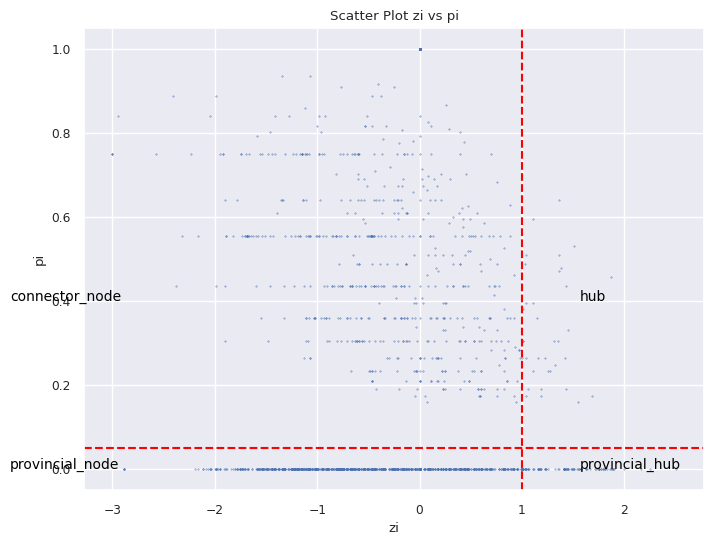

In [ ]:
mask = (df_labels['densidad']>= 0.04) & (df_labels['densidad']<= 0.041) & (df_labels['estadio']== 'N3')
df_plot_040 = df_labels.loc[mask]

plt.scatter(df_plot_040['zi'], df_plot_040['pi'], s=0.1)
plt.title('Scatter Plot zi vs pi')
plt.xlabel('zi')
plt.ylabel('pi')
min_zi = min(df_plot_040['zi'])
max_zi = max(df_plot_040['zi'])
plt.axvline(x = 1, color='red', linestyle='--', label='limite zi')
plt.axhline(y= 0.05, color='red', linestyle='--', label='limite pi')

print (f'zi: {min_zi} a {max_zi}')

plt.text(1.56, 0.4, 'hub', fontsize=10, color='black')
plt.text(-4, 0.4, 'connector_node', fontsize=10, color='black')
plt.text(1.56, 0, 'provincial_hub', fontsize=10, color='black')
plt.text(-4, 0, 'provincial_node', fontsize=10, color='black')
min_pi = min(df_plot_040['pi'])
max_pi = max(df_plot_040['pi'])
print (f'zi: {min_pi} a {max_pi}')

zi: -7.0 a 3.537764214218853
zi: 0.0 a 1.0


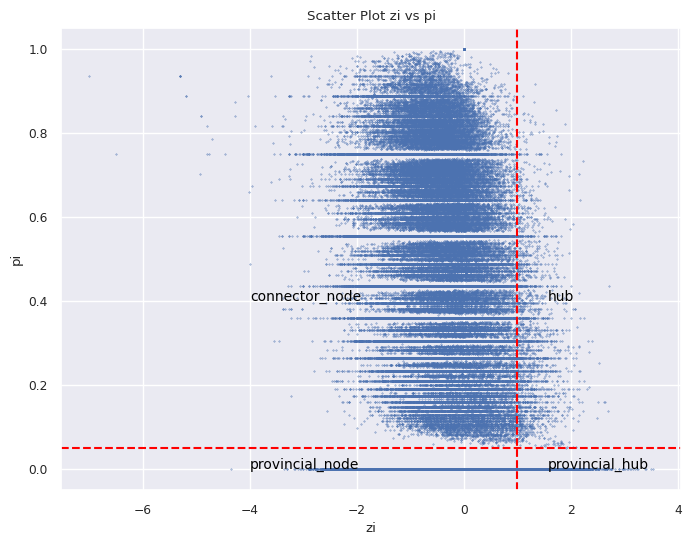

In [ ]:
plt.scatter(df_labels['zi'], df_labels['pi'], s=0.1)
plt.title('Scatter Plot zi vs pi')
plt.xlabel('zi')
plt.ylabel('pi')
min_zi = min(df_labels['zi'])
max_zi = max(df_labels['zi'])
plt.axvline(x = 1, color='red', linestyle='--', label='limite zi')
plt.axhline(y= 0.05, color='red', linestyle='--', label='limite pi')

print (f'zi: {min_zi} a {max_zi}')

plt.text(1.56, 0.4, 'hub', fontsize=10, color='black')
plt.text(-4, 0.4, 'connector_node', fontsize=10, color='black')
plt.text(1.56, 0, 'provincial_hub', fontsize=10, color='black')
plt.text(-4, 0, 'provincial_node', fontsize=10, color='black')
min_pi = min(df_labels['pi'])
max_pi = max(df_labels['pi'])
print (f'zi: {min_pi} a {max_pi}')

In [ ]:
#df_result = df_labels[['zi', 'pi', 'label']].drop_duplicates()
#df_result
conteo_labels = df_labels['densidad'].value_counts()
conteo_labels




0.025    8352
0.030    8352
0.145    8352
0.140    8352
0.135    8352
0.130    8352
0.125    8352
0.120    8352
0.115    8352
0.110    8352
0.105    8352
0.100    8352
0.095    8352
0.090    8352
0.085    8352
0.080    8352
0.075    8352
0.070    8352
0.065    8352
0.060    8352
0.055    8352
0.050    8352
0.045    8352
0.040    8352
0.035    8352
0.150    8352
Name: densidad, dtype: int64

In [ ]:
max (df_labels['zi'])

3.537764214218853

In [ ]:
df_labels_w = df_labels.loc[(df_labels['estadio'] == 'W')]
promedio_metrica = df_labels.groupby(['densidad', 'estadio', 'sujeto', 'label'])['nodo'].count().reset_index()
promedio_metrica

pivot = promedio_metrica.pivot(index=['densidad', 'estadio', 'sujeto'], columns='label', values='nodo')

# Rellenar NA
pivot = pivot.fillna(0).astype(int)

# Reordenar columnas
pivot = pivot[sorted(pivot.columns)]
pivot



label                    connector_node  hub  provincial_hub  provincial_node
densidad estadio sujeto                                                      
0.025    N1      1                   43    1               7               65
                 10                  41    0               6               69
                 11                  63    1               3               49
                 12                  35    0               8               73
                 13                  45    0               6               65
...                                 ...  ...             ...              ...
0.150    W       5                   89    0               0               27
                 6                   87    0               2               27
                 7                   92    0               0               24
                 8                   96    0               0               20
                 9                   62    1               0               53

[1872 rows x 4 columns]

In [ ]:
pivot_df = pd.DataFrame(pivot)
pivot_df.reset_index(inplace=True)
pivot_df = pivot_df.sort_values(by=["densidad", 'sujeto', "estadio"], ascending = True)
pivot_df

label  densidad estadio sujeto  connector_node  hub  provincial_hub  \
0         0.025      N1      1              43    1               7   
18        0.025      N2      1              36    1               8   
36        0.025      N3      1              27    0              10   
54        0.025       W      1              56    1               5   
1         0.025      N1     10              41    0               6   
...         ...     ...    ...             ...  ...             ...   
1870      0.150       W      8              96    0               0   
1817      0.150      N1      9              78    1               3   
1835      0.150      N2      9              77    1               5   
1853      0.150      N3      9              83    0               0   
1871      0.150       W      9              62    1               0   

label  provincial_node  
0                   65  
18                  71  
36                  79  
54                  54  
1                   69  
...                ...  
1870                20  
1817                34  
1835                33  
1853                33  
1871                53  

[1872 rows x 7 columns]

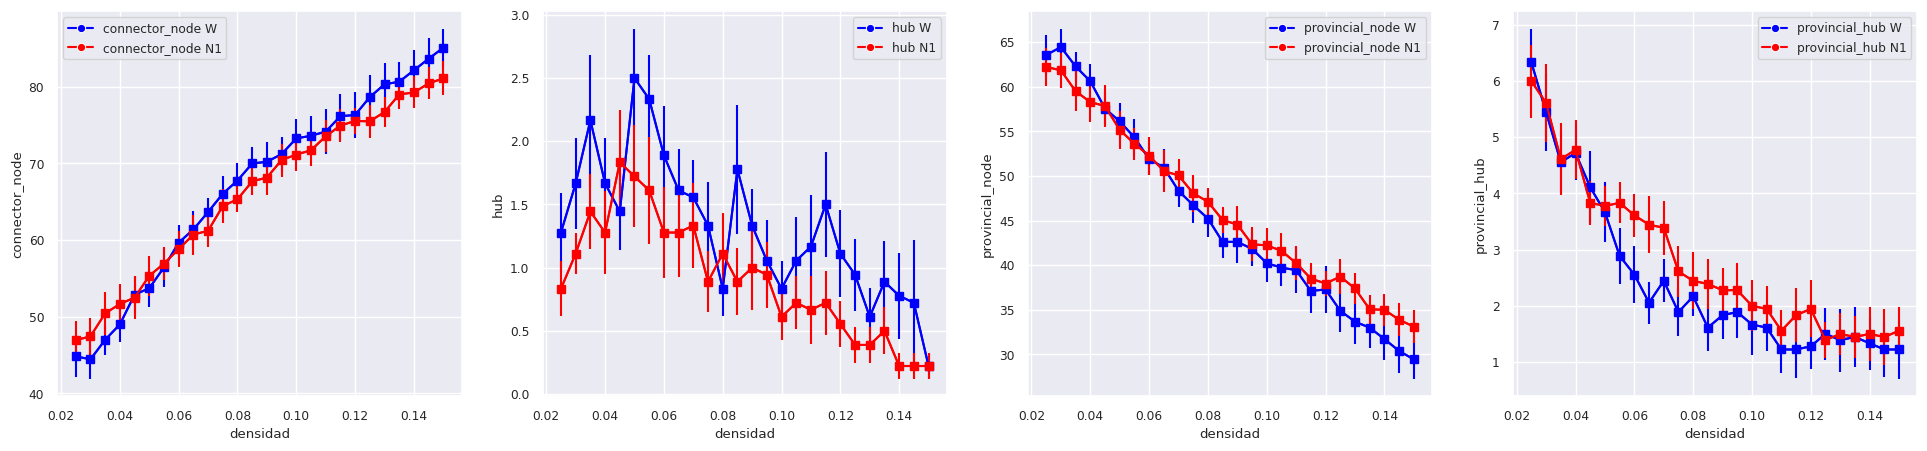

In [ ]:
def comparar_tipo_nodos(estadios, metrica, ax):

  for e in estadios:
    df_metricas_tmp = pivot_df.loc[pivot_df['estadio'] == e]

    # Obtengo los datos que voy a necesitar para graficar W
    promedio_metrica = df_metricas_tmp.groupby('densidad')[metrica].mean().reset_index()
    sem_por_densidad = calcular_sem_por_densidad(df_metricas_tmp, metrica)

    # Grafico W
    ax = sns.lineplot(x='densidad', y = metrica, data=promedio_metrica, label=f'{metrica} {e}', marker='o', color=colores[e], ax=ax)
    ax.errorbar(promedio_metrica['densidad'], promedio_metrica[metrica], yerr=sem_por_densidad, fmt='-s', color=colores[e])

  p_valor_t = 1

  for d in densidades:

    # Filtro por la densidad
    mask_e = (pivot_df['estadio'] == estadios[0]) & (pivot_df['densidad'] == d)
    df_mod_est_d = pivot_df.loc[mask_e]

    mask_r = (pivot_df['estadio'] == estadios[1]) & (pivot_df['densidad'] == d)
    df_mod_rnd_d = pivot_df.loc[mask_r]

    # Calculo el estadístico
    t_stat, p_valor_t = calcular_significancia(df_mod_est_d[metrica], df_mod_rnd_d[metrica])
    #if p_valor_t < 0.05:
      #plt.text(d, 0.15, '*', color='black', fontsize=10)  # 's' controla el tamaño del marcador

# Crear una fila de 3 subgráficos
fig, axs = plt.subplots(1, 4, figsize=(24, 5))

# Llamar a la función para cada métrica
estadios = ['W', 'N1']
#Todo arreglar provicial_hub
metricas = ['connector_node', 'hub', 'provincial_node', 'provincial_hub']
#metricas = ['connector_node', 'hub', 'provincial_node']

for i, metrica in enumerate(metricas):
    comparar_tipo_nodos(estadios, metrica, axs[i])

plt.show()

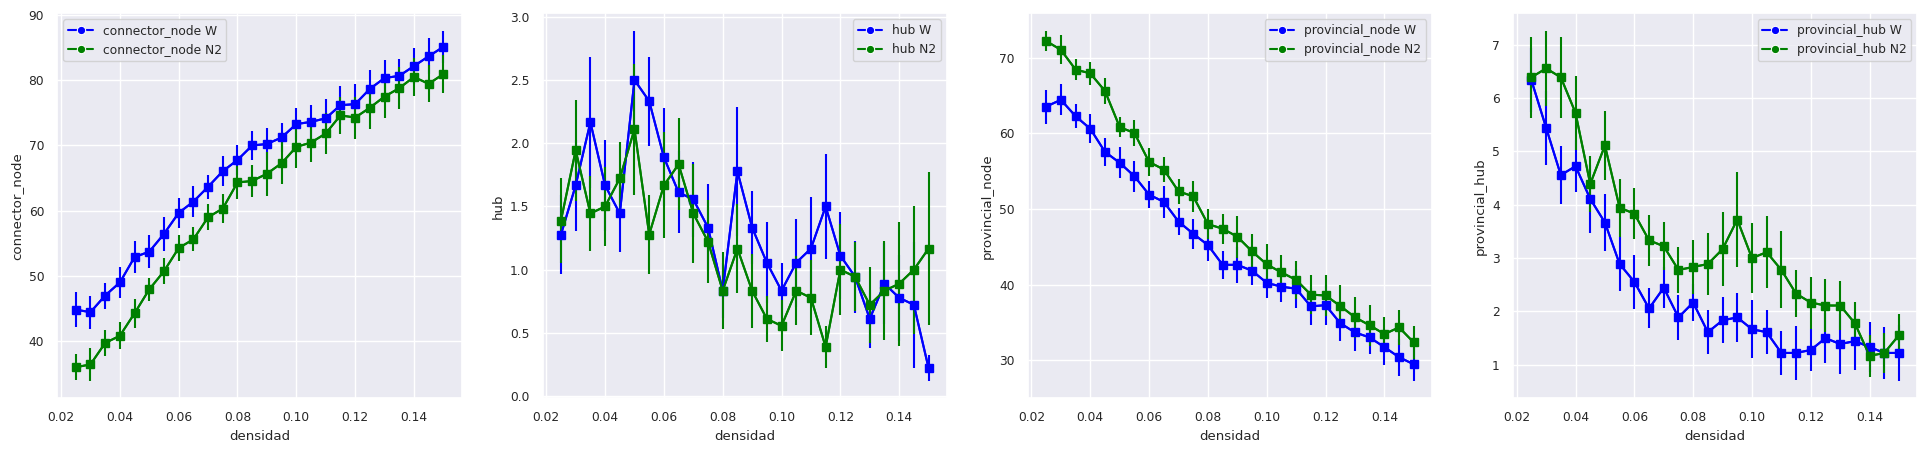

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(24, 5))

# Llamar a la función para cada métrica
estadios = ['W', 'N2']
metricas = ['connector_node', 'hub', 'provincial_node', 'provincial_hub']

for i, metrica in enumerate(metricas):
    comparar_tipo_nodos(estadios, metrica, axs[i])

plt.show()

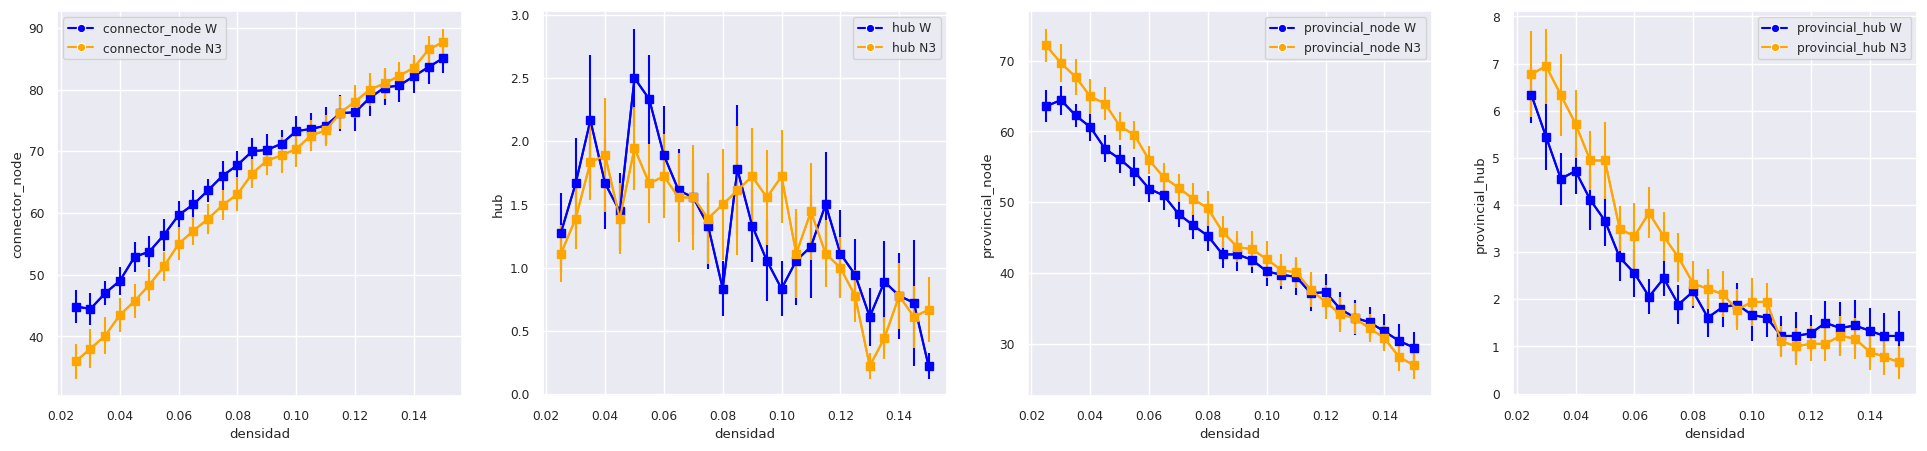

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(24, 5))

# Llamar a la función para cada métrica
estadios = ['W', 'N3']
metricas = ['connector_node', 'hub', 'provincial_node', 'provincial_hub']

for i, metrica in enumerate(metricas):
    comparar_tipo_nodos(estadios, metrica, axs[i])

plt.show()

## Item 2

. Nuevamente usando las matrices de adyacencia pesadas promedio para cada estadío
(definidas en la Tarea 1), elegir un valor de δ que resulte particularmente interesante a
partir de los análisis anteriores, y visualizar los Hubs y los Provincial Hubs en el grafo
coloreando el nodo y sus enlaces.

In [ ]:
ady_n1
ady_n2
ady_n3


densidad_interesante_w, densidad_interesante_n1, densidad_interesante_n2, densidad_interesante_n3 = 0.05, 0.05, 0.05, 0.05
densidad_interesante_w, densidad_interesante_n1, densidad_interesante_n2, densidad_interesante_n3 = 0.04, 0.04, 0.04, 0.04


In [ ]:

def graficar_grafo_por_tipo_nodo(G, labels, ax, titulo=""):


    unique_labels = list(set(labels.values()))
    print (unique_labels)
    label_to_number = {label: i + 1 for i, label in enumerate(unique_labels)}
    print (label_to_number)
    num_labels = len(unique_labels)
    print (num_labels)

    #cm = LinearSegmentedColormap.from_list('custom_colormap', ['#1f78b4', '#33a02c', '#e31a1c'], N=num_labels)
    cm = {'hub': 'red', 'provincial_node': 'lightgray', 'connector_node': 'lightgray', 'provincial_hub': 'yellow'}
    print (cm)
    # Obtener colores basados en la partición
    #node_color = [cm(label_to_number[labels[node]]) for node in G.nodes()]
    node_color = [cm[labels[node]] for node in G.nodes()]

    print(node_color)

    n_size = 150  # Tamaño de nodos constante

    ax.set_title('Grafo por label ' + titulo, fontsize=14)

    # Utilizar el layout de manera similar a como lo estabas haciendo
    layout = dict(zip(range(116), np.array([RegionsNames[6].values, RegionsNames[7].values]).T))

    # Crear etiquetas para los nodos
    node_labels = {n: str(n) for n in G.nodes()}

    # Dibujar el grafo
    nx.draw(G, layout, node_size=n_size, node_color = node_color, labels=node_labels, cmap=cm, ax = ax)

    handles = []
    for i, label in enumerate(unique_labels):
        handle = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cm[label], markersize=10, label=label)
        handles.append(handle)

    ax.legend(handles=handles, title='Labels', loc='upper left', bbox_to_anchor=(1, 1))


In [ ]:
def calcular_y_dubujar_grafo_tipo_nodo(matriz, estadio, densidad, ax):
  G = binarizar_matriz(matriz, densidad)
  zi_zcores = calculate_zi_scores(G)
  p_i_coeficients =  calculate_participation_coeficients(G)

  m_ady_labels = []
  labels_info = generar_labels(G, densidad, zi_zcores, p_i_coeficients, m_ady_labels, estadio, -1)


  df = pd.DataFrame(labels_info, columns=['densidad', 'nodo', 'zi', 'pi', 'comunidad', 'label', 'estadio', 'sujeto'])
  dic = df.set_index('nodo')['label'].to_dict()


  graficar_grafo_por_tipo_nodo(G, dic, ax, titulo = estadio)


['connector_node', 'provincial_node', 'hub', 'provincial_hub']
{'connector_node': 1, 'provincial_node': 2, 'hub': 3, 'provincial_hub': 4}
4
{'hub': 'red', 'provincial_node': 'lightgray', 'connector_node': 'lightgray', 'provincial_hub': 'yellow'}
['lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'yellow', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'yellow', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'ligh

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(
/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


['connector_node', 'provincial_hub', 'hub', 'provincial_node']
{'connector_node': 1, 'provincial_hub': 2, 'hub': 3, 'provincial_node': 4}
4
{'hub': 'red', 'provincial_node': 'lightgray', 'connector_node': 'lightgray', 'provincial_hub': 'yellow'}
['lightgray', 'lightgray', 'yellow', 'lightgray', 'lightgray', 'lightgray', 'red', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'yellow', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray'

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(
/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


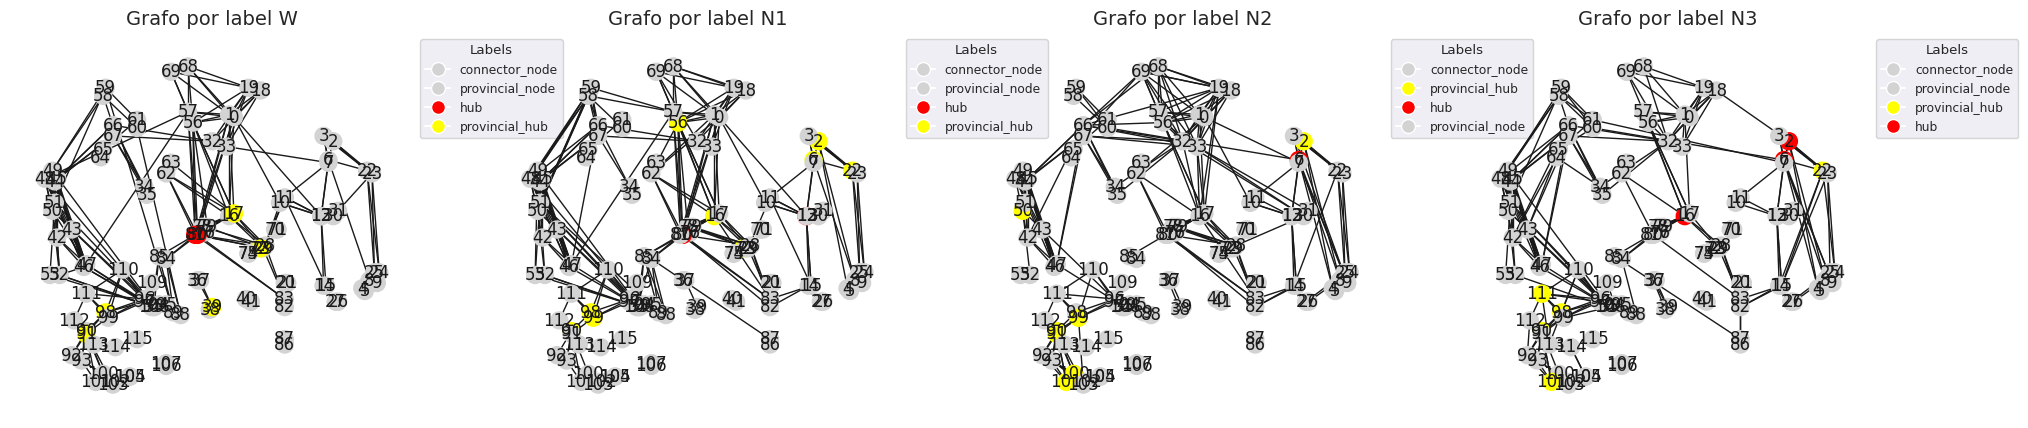

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(24, 5))


calcular_y_dubujar_grafo_tipo_nodo(ady_w, 'W', densidad_interesante_w, axs[0])
calcular_y_dubujar_grafo_tipo_nodo(ady_n1, 'N1', densidad_interesante_n1, axs[1])
calcular_y_dubujar_grafo_tipo_nodo(ady_n2, 'N2', densidad_interesante_n2, axs[2])
calcular_y_dubujar_grafo_tipo_nodo(ady_n3, 'N3', densidad_interesante_n3, axs[3])
plt.show()
